# Deep learning model validation 

This notebook can be used to validate a deep learning model. At the top the data and model can be loaded into memory. Then the validation functions are defined. After this, the models are validated and lastly there are a few visualisation cells.

In [1]:
import sys, os, fnmatch, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.dirname(os.getcwd()))

from config import PATH_DATA_PROCESSED_DL, PATH_MODELS, PATH_METADATA

# 1. Preparing data, model, and helper functions

## Configuration variables

In [2]:
N_AVERAGE = 30
# MODEL_NAME = 'Fully_connected_regressor_FINAL_LOCAL.hdf5'

## Load data

In [3]:
from sklearn.model_selection import train_test_split

# Step 1: Get all the files in the output folder
file_names = os.listdir(PATH_DATA_PROCESSED_DL)

# Step 2: Get the full paths of the files (without extensions)
files = [os.path.splitext(os.path.join(PATH_DATA_PROCESSED_DL, file_name))[0] for file_name in fnmatch.filter(file_names, "*.zarr")]

# Step 3: Load all the metadata
frames = []

for idx, feature_file in enumerate(files):
    df_metadata = pd.read_csv(feature_file.replace("processed_raw_", "processed_metadata_") + ".csv")
    frames.append(df_metadata)

df_metadata = pd.concat(frames) 

# Step 4: Add missing age information based on the age group the subject is in
df_metadata['age_months'].fillna(df_metadata['age_group'], inplace=True)
df_metadata['age_days'].fillna(df_metadata['age_group']*30, inplace=True)
df_metadata['age_years'].fillna(df_metadata['age_group']/12, inplace=True)

# Step 5: List all the unique subject IDs
subject_ids = sorted(list(set(df_metadata["code"].tolist())))

In [4]:
from sklearn.model_selection import train_test_split

IDs_train, IDs_temp = train_test_split(subject_ids, test_size=0.3, random_state=42)
IDs_test, IDs_val = train_test_split(IDs_temp, test_size=0.5, random_state=42)

In [5]:
df_metadata.head()

,code,cnt_path,cnt_file,age_group,age_days,age_months,age_years
0,23,/Volumes/Seagate Expansion Drive/ePodium/Data/...,023_35_mc_mmn36,35,1052.0,35.066667,2.922222
0,337,/Volumes/Seagate Expansion Drive/ePodium/Data/...,337_23_jc_mmn_36_wk,23,692.0,23.066667,1.922222
0,456,/Volumes/Seagate Expansion Drive/ePodium/Data/...,456_23_md_mmn36_wk,23,691.0,23.033333,1.919444
0,328,/Volumes/Seagate Expansion Drive/ePodium/Data/...,328_23_jc_mmn36_wk,23,699.0,23.300000,1.941667
0,314,/Volumes/Seagate Expansion Drive/ePodium/Data/...,314_29_mmn_36_wk,29,877.0,29.233333,2.436111


## Load model

In [289]:
# import tensorflow as tf
# import tensorflow_addons as tfa

# model_path = os.path.join(PATH_MODELS, MODEL_NAME)
# loaded_model = tf.keras.models.load_model(model_path)

## Helper functions for validation

### Make predictions: Divide all epochs in non-overlapping subsets, average and predict, take median

In [327]:
from sklearn.utils import resample

def chunks(lst, n):
    """Yield successive n-sized chunks from list."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def make_predictions(model, IDs):
    """Takes in the IDs of the test subjects, divides all epochs in subsets of 30 and averages. 
        Final prediction for the subject is the median of all predictions on these subsets."""
    
    # Step 1: Make empty DataFrame to store the predictions in
    column_names = ["code", "age_group", "true_age", "predicted_age"]
#     for i in range(100):
#         column_names.append(f"predicted_age_{i+1}")
    
    df_pred = pd.DataFrame(columns = column_names)
        
    # Step 2: Iterate over subjects
    for ID in IDs:
        
        # Step 3: Find all files of a subject
        df_temp = df_metadata[df_metadata['code'] == ID]
    
        # Step 4: Find all the age groups the subject was found in
        ages_subject = sorted(list(set(df_temp['age_group'].tolist())))
        
        # Step 5: Loop over all the age groups the subject is in
        for age_group in ages_subject:            
            X_data = np.zeros((0, 30, 501))
            X_averaged_subsets = np.zeros((0, 30, 501))
            
            # Step 6: Concatenate data of files in the same age group
            for i, metadata_file in df_temp[df_temp['age_group'] == age_group].iterrows():
                filename = os.path.join(PATH_DATA_PROCESSED_DL, 'processed_raw_' + metadata_file['cnt_file'] + '.zarr')
                data_signal = zarr.open(os.path.join(filename), mode='r')
                                
                X_data = np.concatenate((X_data, data_signal), axis=0)
            
            np.random.shuffle(X_data) # Shuffle data for randomly picking epochs without replacement
            
            for subset in chunks(X_data, 30):
                X_data_mean = np.mean(subset[:,:,:], axis=0) # Average all epochs in subset
                X_data_mean = np.expand_dims(X_data_mean, axis=0)
                X_averaged_subsets = np.concatenate((X_averaged_subsets, X_data_mean), axis=0)
            
            X = np.swapaxes(X_averaged_subsets, 1, 2)
                                            
            # Step 7: Predict age of the averaged epochs
            predicted_ages = model.predict(X).flatten()
            predicted_age = np.median(predicted_ages)
            
            true_age = df_temp[df_temp['age_group'] == age_group]['age_months'].values[0]
            
            # Step 8: Create a row for the predictions DataFrame
            df_row = {"code": ID, 
                      "age_group": age_group, 
                      "true_age": true_age, 
                      "predicted_age": predicted_age}
            
#             # Step 9A: Bootstrapping, predict 100 ages on resampled epochs, add to row
#             # MARK: This is a sub-par manner to bootstrap. 
#             for i in range(100):
#                 resampled_ages = resample(predicted_ages)
#                 predicted_age_bootstr = np.median(resampled_ages)
                
#                 df_row[f"predicted_age_{i+1}"] = predicted_age_bootstr  
            
#             # Step 9B
#             # MARK: This is a better way to bootstrap, but most likely (too) computationally intesive
#             for i in range(2): # MARK: Verify that this value is also used when validating
#                 temp_X_data = resample(X_data)
                
#                 for subset in chunks(X_data, 30):
#                     X_data_mean = np.mean(subset[:,:,:], axis=0) # Average all epochs in subset
#                     X_data_mean = np.expand_dims(X_data_mean, axis=0)
#                     X_averaged_subsets = np.concatenate((X_averaged_subsets, X_data_mean), axis=0)

#                 X = np.swapaxes(X_averaged_subsets, 1, 2)

#                 # Step 7: Predict age of the averaged epochs
#                 predicted_ages_bootstr = model.predict(X).flatten()
#                 predicted_age_bootstr = np.median(predicted_ages_bootstr)
                
#                 df_row[f"predicted_age_{i+1}"] = predicted_age_bootstr  
            
            # Step 10: Add the row to the DataFrame
            df_pred = df_pred.append(df_row, ignore_index=True)
            
    return df_pred

## Error stability

Definition of error stability (Vandenbosch et al., 2018): 

_"Stability was assessed as the correlation between the prediction errors (estimated minus actual age) of subjects at baseline with their own prediction error at follow-up."_

Take the prediction error (of a subject) at time 1 and compare it to the prediction error at time 2, take the prediction error at time 2 and compare it to time 3, take the prediction error at time 3 and compare it to time 4. You can then make two lists of errors: TIME_N and TIME_N+1 and look at the correlation between those two. 

A stable error then would mean a positive correlation, because if error is low at time n, you expect it to be low at time n+1 as well. 

### Divide all epochs in non-overlapping subsets, average and predict, take median, calculate stability

In [301]:
from scipy.stats import pearsonr

def error_stability(dataframe):
    
    errors_time_N = []
    errors_time_N1 = []
    
    # Step 1: Get the unique subject IDs
    subject_IDs = list(set(dataframe['code']))
    
    # Step 2: Loop over all subjects
    for ID in subject_IDs:
        
        # Step 3: Get the indices in the dataframes for the subject with ID
        idx = dataframe.loc[dataframe['code'] == ID].index.tolist()
        
        # Step 4: Get the different ages we have epochs from of this subject
        ages_subject = sorted(list(set(dataframe['true_age'].loc[idx])))
        
        # Step 5: If the subject has only recording from one age, we can't compare to a follow-up
        if len(ages_subject) == 1:
            continue    
            
        prev_prediction_error = None
        curr_prediction_error = None
        
        # Step 6: Only look at the epochs at a specific age
        for true_age in ages_subject:
            prev_prediction_error = curr_prediction_error
            
            # Step 7: Lookup the predicted age for this subject at this age
            data_subject = dataframe.loc[dataframe['code'] == ID]
            predicted_age = data_subject.loc[data_subject['true_age'] == true_age]['predicted_age'].values[0]            
            curr_prediction_error = predicted_age - true_age
            
            # Step 8: If there are two values to compare, i.e. time N and time N+1, add them to the lists
            if prev_prediction_error and curr_prediction_error:
                errors_time_N.append(prev_prediction_error)
                errors_time_N1.append(curr_prediction_error)
                
    # Step 9: Calculate correlation between prediction error and follow-up
    corr, _ = pearsonr(errors_time_N, errors_time_N1)
    
    return corr, errors_time_N, errors_time_N1

## Relation brain age and vocabulary

In [302]:
vocabulary_filename = "CDIinfo_combined.csv"
vocabulary_dataframe = pd.read_csv(os.path.join(PATH_METADATA, vocabulary_filename))

In [303]:
vocabulary_dataframe.head()

,code,age_months,productive,receptive
0,0,17,45,177
1,1,29,506,580
2,1,35,608,674
3,3,29,357,512
4,4,17,79,215


In [333]:
from scipy.stats import pearsonr

def correlation_brainage_vocabulary(dataframe):
    
#     print(dataframe)
    
    # Step 1: Make a list of age groups to loop over, we don't have vocabulary info of other ages
    age_groups = [17, 23, 29, 35]
    categories = ["productive", "receptive"]
    
    # Step 2: Make empty Dict to store the results in
    
    results_dict = {} 
    
    # Step 3: Get the unique subject IDs
    subject_IDs = list(set(dataframe['code']))
    
    # Step 4: Loop over categories and age groups
    for category in categories:
        results_dict[category] = {}
        
        for age_group in age_groups: 
            results_dict[category][age_group] = {}
            
            brain_age_gaps = []
            vocabulary_sizes = []
            
            # Step 5: Iterate over subjects
            for ID in subject_IDs:
#                 print(f"==============[ SUBJECT {ID} ]==============")
                
                # Step 6: Get the indices of the subject in the dataframes for this age group
                idx = dataframe.loc[dataframe['code'] == ID].loc[dataframe['age_group'] == age_group].index.tolist()        
#                 print(f"INDICES {idx}")
                
                if len(idx) == 0:
                    # No EEG data for this subject in this age group
                    continue

                # Step 7: Determine whether we have vocabulary information or not
                vocabulary_size = vocabulary_dataframe.loc[vocabulary_dataframe['code'] == ID].loc[vocabulary_dataframe['age_months'] == age_group][category].values
                vocabulary_size = vocabulary_size[0] if len(vocabulary_size) > 0 else None

                if vocabulary_size is None:
                    # No vocabulary data for this subject in this age group
                    continue

                # Step 8: Lookup the true age for this subject in this age group
                data_subject = dataframe.loc[dataframe['code'] == ID]
                true_age = data_subject.loc[dataframe['age_group'] == age_group]['true_age'].values[0]
                
#                 print("==============[ DATA SUBJECT ]==============")
#                 print(data_subject)
                
#                 print(f"true_age: {true_age}")
                
                if not (age_group in data_subject['age_group'].values):
                    continue
                    
                # Step 9: Lookup the predicted age for this subject at this age
                predicted_age = data_subject.loc[data_subject['true_age'] == true_age]['predicted_age'].values[0]
                
#                 print(f"predicted_age: {predicted_age}")
                
                # Step 10: Predict age for all epochs at that age and take median as final prediction for all of them
                prediction_error = predicted_age - true_age

#                 print(f"prediction_error: {prediction_error}")
#                 print(f"vocabulary_size: {vocabulary_size}")
                
                brain_age_gaps.append(prediction_error)
                vocabulary_sizes.append(vocabulary_size)
                
            # Step 11: Look at correlation between prediction error and vocabulary
#             print(f"Number of data points: {len(brain_age_gaps)}")
            corr, _ = pearsonr(brain_age_gaps, vocabulary_sizes)
#             print(f"Pearsons correlation: {corr:.3f}")
            
            results_dict[category][age_group]["correlation"] = corr
            results_dict[category][age_group]["brain_age_gap"] = brain_age_gaps
            results_dict[category][age_group]["vocabulary_size"] = vocabulary_sizes
    
    return results_dict

In [312]:
df_pred

,code,age_group,true_age,predicted_age
0,152.0,11.0,10.833333,11.906328
1,152.0,29.0,29.833333,29.782562
2,152.0,35.0,35.000000,32.461674
3,152.0,41.0,40.933333,36.657009
4,18.0,11.0,11.033333,18.491217
5,18.0,17.0,17.300000,14.701675
6,18.0,23.0,23.000000,27.707409
7,18.0,29.0,29.466667,26.554285
8,18.0,35.0,35.200000,24.525627
9,18.0,41.0,41.000000,36.430695


## Relation brain age and dyslexia

In [305]:
dyslexia_filename = "Screening_children5a_summary_new.txt"
dyslexia_dataframe = pd.read_csv(os.path.join(PATH_METADATA, dyslexia_filename), delimiter = "\t")
dyslexia_dataframe = dyslexia_dataframe[['id_child', 'dyslexicAtMidGroup3DDP']]
dyslexia_dataframe = dyslexia_dataframe.loc[dyslexia_dataframe['dyslexicAtMidGroup3DDP'].isin(['0', '1'])]

In [306]:
dyslexia_dataframe.head(10)

,id_child,dyslexicAtMidGroup3DDP
0,001,1
2,003,0
4,005,0
5,006,0
6,007,0
7,008,0
8,009,1
9,010,1
13,014,0
14,015,0


In [307]:
def calculate_dyslexia_dataframe(dataframe):
    
    # Step 1: Copy original dataframe
    df_dyslexia = dataframe
    df_dyslexia['dyslexia'] = None
    
    # Step 2: Get the unique subject IDs
    subject_IDs = list(set(dataframe['code']))
    
    for ID in subject_IDs:
        
        # Step 3: Determine whether we have dyslexia information
        dyslexia = dyslexia_dataframe.loc[dyslexia_dataframe['id_child'] == str(int(ID)).zfill(3)]['dyslexicAtMidGroup3DDP'].values
        dyslexia = dyslexia[0] if len(dyslexia) > 0 else None

        if dyslexia is None:
            continue
        
        df_dyslexia.loc[df_dyslexia['code'] == ID, 'dyslexia'] = dyslexia
    
    return df_dyslexia

def brain_ages_dyslexia(dyslexia_dataframe, age_group=17):
    df_age_group = dyslexia_dataframe[dyslexia_dataframe['age_group'] == age_group]
    
    brain_age_gaps_dyslexia = df_age_group.loc[df_age_group['dyslexia'] == '1']['predicted_age'] - df_age_group.loc[df_age_group['dyslexia'] == '1']['true_age']
    brain_age_gaps_no_dyslexia = df_age_group.loc[df_age_group['dyslexia'] == '0']['predicted_age'] - df_age_group.loc[df_age_group['dyslexia'] == '0']['true_age']
    
    return brain_age_gaps_dyslexia, brain_age_gaps_no_dyslexia

# 2. Model validation (Test/Train, all models)

In [456]:
models = ['Fully_connected_regressor_FINAL_LOCAL.hdf5',
          'CNN_regressor_FINAL_LOCAL.hdf5',
          'ResNet_regressor_FINAL_LOCAL.hdf5',
          'Encoder_regressor_FINAL_LOCAL.hdf5',
          'TimeCNN_regressor_FINAL_LOCAL.hdf5',
          'BLSTM_regressor_FINAL_LOCAL.hdf5',
          'Inception_regressor_FINAL_LOCAL.hdf5'
]

## 2.1 Test set: Validation of all models

In [388]:
%%time

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import r2_score
from scipy.stats import kstest
from statistics import mean
import zarr

# model_performance_test = {}

for model in models:
    # Step 1: Load model
    model_path = os.path.join(PATH_MODELS, model)

    loaded_model = tf.keras.models.load_model(model_path)
    
    model_performance_test[model] = {}
    
    # Step 2: Calculate MAE, RMSE, R2
    df_pred = make_predictions(loaded_model, IDs_test) 
    
    MAE = mean_absolute_error(df_pred['true_age'], df_pred['predicted_age'])
    RMSE = mean_squared_error(df_pred['true_age'], df_pred['predicted_age'], squared=False)
    rsquared = r2_score(df_pred['true_age'], df_pred['predicted_age'])
    
    model_performance_test[model]['code'] = df_pred['code']
    model_performance_test[model]['age_group'] = df_pred['age_group']
    model_performance_test[model]['y_true'] = df_pred['true_age']
    model_performance_test[model]['y_pred'] = df_pred['predicted_age']
    
#     for i in range(2):
#         model_performance_test[model][f'predicted_age_{i+1}'] = df_pred[f"predicted_age_{i+1}"]
    
    model_performance_test[model]['MAE'] = MAE
    model_performance_test[model]['RMSE'] = RMSE
    model_performance_test[model]['rsquared'] = rsquared
        
    # Step 3: Calculate error stability
    corr, errors_time_N, errors_time_N1 = error_stability(df_pred)
    
    model_performance_test[model]['corr'] = corr
    model_performance_test[model]['errors_time_N'] = errors_time_N
    model_performance_test[model]['errors_time_N1'] = errors_time_N1
    
    # Step 4: Vocabulary size
    results_vocabulary = correlation_brainage_vocabulary(df_pred)
    
    age_groups = [17, 23, 29, 35]
    categories = ["productive", "receptive"]
    
    for category in categories:
        for age_group in age_groups:  
                model_performance_test[model][f'vocabulary_correlation_{age_group}_{category}'] = results_vocabulary[category][age_group]["correlation"]
                model_performance_test[model][f'brain_age_gaps_{age_group}_{category}'] = results_vocabulary[category][age_group]["brain_age_gap"]
                model_performance_test[model][f'vocabulary_sizes_{age_group}_{category}'] = results_vocabulary[category][age_group]["vocabulary_size"]
    
    dys_df = calculate_dyslexia_dataframe(df_pred)
    dys_brainage_11, no_dys_brainage_11 = brain_ages_dyslexia(dys_df, age_group=11)
    dys_brainage_17, no_dys_brainage_17 = brain_ages_dyslexia(dys_df, age_group=17)
    dys_brainage_23, no_dys_brainage_23 = brain_ages_dyslexia(dys_df, age_group=23)
    dys_brainage_29, no_dys_brainage_29 = brain_ages_dyslexia(dys_df, age_group=29)
    dys_brainage_35, no_dys_brainage_35 = brain_ages_dyslexia(dys_df, age_group=35)
    dys_brainage_41, no_dys_brainage_41 = brain_ages_dyslexia(dys_df, age_group=41)
    dys_brainage_47, no_dys_brainage_47 = brain_ages_dyslexia(dys_df, age_group=47)
    
    model_performance_test[model]['dys_brainage_11'] = dys_brainage_11
    model_performance_test[model]['no_dys_brainage_11'] = no_dys_brainage_11
    
    model_performance_test[model]['dys_brainage_17'] = dys_brainage_17
    model_performance_test[model]['no_dys_brainage_17'] = no_dys_brainage_17
    
    model_performance_test[model]['dys_brainage_23'] = dys_brainage_23
    model_performance_test[model]['no_dys_brainage_23'] = no_dys_brainage_23
    
    model_performance_test[model]['dys_brainage_29'] = dys_brainage_29
    model_performance_test[model]['no_dys_brainage_29'] = no_dys_brainage_29
    
    model_performance_test[model]['dys_brainage_35'] = dys_brainage_35
    model_performance_test[model]['no_dys_brainage_35'] = no_dys_brainage_35
    
    model_performance_test[model]['dys_brainage_41'] = dys_brainage_41
    model_performance_test[model]['no_dys_brainage_41'] = no_dys_brainage_41
    
    model_performance_test[model]['dys_brainage_47'] = dys_brainage_47
    model_performance_test[model]['no_dys_brainage_47'] = no_dys_brainage_47
    
    
    # Print all results
    print(f"=================== MODEL: {model} ===================") 
    print(f"---- MAE: {MAE}")
    print(f"---- RMSE: {RMSE}")
    print(f"---- R-squared: {rsquared}")
    print(f"---- Error stability: {corr}")
    print(f"---- Vocabulary correlations")
    for category in categories:
        for age_group in age_groups:  
            print(f"------------ {age_group} {category}: {results_vocabulary[category][age_group]['correlation']}")
    
    print(f"---- Brain age distributions dyslexia")
    print(f"------------ 11: Dyslexia mean {mean(dys_brainage_11)} / No dyslexia mean: {mean(no_dys_brainage_11)}")
    ks = kstest(dys_brainage_11, no_dys_brainage_11, alternative='less')
    print(f"------------ 11: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")
    
    print(f"------------ 17: Dyslexia mean {mean(dys_brainage_17)} / No dyslexia mean: {mean(no_dys_brainage_17)}")
    ks = kstest(dys_brainage_17, no_dys_brainage_17, alternative='less')
    print(f"------------ 17: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")

    print(f"------------ 23: Dyslexia mean {mean(dys_brainage_23)} / No dyslexia mean: {mean(no_dys_brainage_23)}")
    ks = kstest(dys_brainage_23, no_dys_brainage_23, alternative='less')
    print(f"------------ 23: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")
    
    print(f"------------ 29: Dyslexia mean {mean(dys_brainage_29)} / No dyslexia mean: {mean(no_dys_brainage_29)}")
    ks = kstest(dys_brainage_29, no_dys_brainage_29, alternative='less')
    print(f"------------ 29: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")
    
    print(f"------------ 35: Dyslexia mean {mean(dys_brainage_35)} / No dyslexia mean: {mean(no_dys_brainage_35)}")
    ks = kstest(dys_brainage_35, no_dys_brainage_35, alternative='less')
    print(f"------------ 35: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")
    
    print(f"------------ 41: Dyslexia mean {mean(dys_brainage_41)} / No dyslexia mean: {mean(no_dys_brainage_41)}")
    ks = kstest(dys_brainage_41, no_dys_brainage_41, alternative='less')
    print(f"------------ 41: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")
    
    # 47: Not enough data for test set
#     print(f"------------ 47: Dyslexia mean {mean(dys_brainage_47)} / No dyslexia mean: {mean(no_dys_brainage_47)}")
#     ks = kstest(dys_brainage_47, no_dys_brainage_47, alternative='less')
#     print(f"------------ 47: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")


=================== MODEL: Inception_regressor_FINAL_LOCAL.hdf5 ===================
---- MAE: 5.631137126719457
---- RMSE: 7.04102788350041
---- R-squared: 0.49207085610193146
---- Error stability: 0.5899486784640526
---- Vocabulary correlations
------------ 17 productive: 0.10451711744615041
------------ 23 productive: 0.29988840164440933
------------ 29 productive: 0.2213175533371145
------------ 35 productive: 0.4025258408414648
------------ 17 receptive: 0.7049358040665956
------------ 23 receptive: 0.34257409421649115
------------ 29 receptive: 0.3464688022065036
------------ 35 receptive: 0.34961848826796155
---- Brain age distributions dyslexia
------------ 11: Dyslexia mean 4.414026721318562 / No dyslexia mean: 5.684964964124892
------------ 11: KS Statistic: 0.08333333333333333 / p-value: 0.9230769230769231
------------ 17: Dyslexia mean 2.405777282714843 / No dyslexia mean: 4.420169668486624
------------ 17: KS Statistic: 0.09090909090909091 / p-value: 0.8958333333333334
----

## 2.2 Validation set: Validation of all models

In [425]:
%%time

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import r2_score
from scipy.stats import kstest
from statistics import mean
import zarr

model_performance_val = {}

for model in models:
    # Step 1: Load model
    model_path = os.path.join(PATH_MODELS, model)

    loaded_model = tf.keras.models.load_model(model_path)
    
    model_performance_val[model] = {}
    
    # Step 2: Calculate MAE, RMSE, R2
    df_pred = make_predictions(loaded_model, IDs_val) 
    
    MAE = mean_absolute_error(df_pred['true_age'], df_pred['predicted_age'])
    RMSE = mean_squared_error(df_pred['true_age'], df_pred['predicted_age'], squared=False)
    rsquared = r2_score(df_pred['true_age'], df_pred['predicted_age'])
    
    model_performance_val[model]['code'] = df_pred['code']
    model_performance_val[model]['age_group'] = df_pred['age_group']
    model_performance_val[model]['y_true'] = df_pred['true_age']
    model_performance_val[model]['y_pred'] = df_pred['predicted_age']
    
#     for i in range(2):
#         model_performance_val[model][f'predicted_age_{i+1}'] = df_pred[f"predicted_age_{i+1}"]
    
    model_performance_val[model]['MAE'] = MAE
    model_performance_val[model]['RMSE'] = RMSE
    model_performance_val[model]['rsquared'] = rsquared
        
    # Step 3: Calculate error stability
    corr, errors_time_N, errors_time_N1 = error_stability(df_pred)
    
    model_performance_val[model]['corr'] = corr
    model_performance_val[model]['errors_time_N'] = errors_time_N
    model_performance_val[model]['errors_time_N1'] = errors_time_N1
    
    # Step 4: Vocabulary size
    results_vocabulary = correlation_brainage_vocabulary(df_pred)
    
    age_groups = [17, 23, 29, 35]
    categories = ["productive", "receptive"]
    
    for category in categories:
        for age_group in age_groups:  
                model_performance_val[model][f'vocabulary_correlation_{age_group}_{category}'] = results_vocabulary[category][age_group]["correlation"]
                model_performance_val[model][f'brain_age_gaps_{age_group}_{category}'] = results_vocabulary[category][age_group]["brain_age_gap"]
                model_performance_val[model][f'vocabulary_sizes_{age_group}_{category}'] = results_vocabulary[category][age_group]["vocabulary_size"]
    
    dys_df = calculate_dyslexia_dataframe(df_pred)
    dys_brainage_11, no_dys_brainage_11 = brain_ages_dyslexia(dys_df, age_group=11)
    dys_brainage_17, no_dys_brainage_17 = brain_ages_dyslexia(dys_df, age_group=17)
    dys_brainage_23, no_dys_brainage_23 = brain_ages_dyslexia(dys_df, age_group=23)
    dys_brainage_29, no_dys_brainage_29 = brain_ages_dyslexia(dys_df, age_group=29)
    dys_brainage_35, no_dys_brainage_35 = brain_ages_dyslexia(dys_df, age_group=35)
    dys_brainage_41, no_dys_brainage_41 = brain_ages_dyslexia(dys_df, age_group=41)
    dys_brainage_47, no_dys_brainage_47 = brain_ages_dyslexia(dys_df, age_group=47)
    
    model_performance_val[model]['dys_brainage_11'] = dys_brainage_11
    model_performance_val[model]['no_dys_brainage_11'] = no_dys_brainage_11
    
    model_performance_val[model]['dys_brainage_17'] = dys_brainage_17
    model_performance_val[model]['no_dys_brainage_17'] = no_dys_brainage_17
    
    model_performance_val[model]['dys_brainage_23'] = dys_brainage_23
    model_performance_val[model]['no_dys_brainage_23'] = no_dys_brainage_23
    
    model_performance_val[model]['dys_brainage_29'] = dys_brainage_29
    model_performance_val[model]['no_dys_brainage_29'] = no_dys_brainage_29
    
    model_performance_val[model]['dys_brainage_35'] = dys_brainage_35
    model_performance_val[model]['no_dys_brainage_35'] = no_dys_brainage_35
    
    model_performance_val[model]['dys_brainage_41'] = dys_brainage_41
    model_performance_val[model]['no_dys_brainage_41'] = no_dys_brainage_41
    
    model_performance_val[model]['dys_brainage_47'] = dys_brainage_47
    model_performance_val[model]['no_dys_brainage_47'] = no_dys_brainage_47
    
    
    # Print all results
    print(f"=================== MODEL: {model} ===================") 
    print(f"---- MAE: {MAE}")
    print(f"---- RMSE: {RMSE}")
    print(f"---- R-squared: {rsquared}")
    print(f"---- Error stability: {corr}")
    print(f"---- Vocabulary correlations")
    for category in categories:
        for age_group in age_groups:  
            print(f"------------ {age_group} {category}: {results_vocabulary[category][age_group]['correlation']}")
    
    print(f"---- Brain age distributions dyslexia")
    print(f"------------ 11: Dyslexia mean {mean(dys_brainage_11)} / No dyslexia mean: {mean(no_dys_brainage_11)}")
    ks = kstest(dys_brainage_11, no_dys_brainage_11, alternative='less')
    print(f"------------ 11: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")
    
    print(f"------------ 17: Dyslexia mean {mean(dys_brainage_17)} / No dyslexia mean: {mean(no_dys_brainage_17)}")
    ks = kstest(dys_brainage_17, no_dys_brainage_17, alternative='less')
    print(f"------------ 17: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")

    print(f"------------ 23: Dyslexia mean {mean(dys_brainage_23)} / No dyslexia mean: {mean(no_dys_brainage_23)}")
    ks = kstest(dys_brainage_23, no_dys_brainage_23, alternative='less')
    print(f"------------ 23: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")
    
    print(f"------------ 29: Dyslexia mean {mean(dys_brainage_29)} / No dyslexia mean: {mean(no_dys_brainage_29)}")
    ks = kstest(dys_brainage_29, no_dys_brainage_29, alternative='less')
    print(f"------------ 29: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")
    
    print(f"------------ 35: Dyslexia mean {mean(dys_brainage_35)} / No dyslexia mean: {mean(no_dys_brainage_35)}")
    ks = kstest(dys_brainage_35, no_dys_brainage_35, alternative='less')
    print(f"------------ 35: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")
    
    print(f"------------ 41: Dyslexia mean {mean(dys_brainage_41)} / No dyslexia mean: {mean(no_dys_brainage_41)}")
    ks = kstest(dys_brainage_41, no_dys_brainage_41, alternative='less')
    print(f"------------ 41: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")
    
    print(f"------------ 47: Dyslexia mean {mean(dys_brainage_47)} / No dyslexia mean: {mean(no_dys_brainage_47)}")
    ks = kstest(dys_brainage_47, no_dys_brainage_47, alternative='less')
    print(f"------------ 47: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")


=================== MODEL: Fully_connected_regressor_FINAL_LOCAL.hdf5 ===================
---- MAE: 5.260998962641201
---- RMSE: 6.897371355917753
---- R-squared: 0.5718991658082304
---- Error stability: 0.6112245185370319
---- Vocabulary correlations
------------ 17 productive: 0.4136665376459001
------------ 23 productive: 0.4380187753250913
------------ 29 productive: 0.1803993087697162
------------ 35 productive: 0.11630393268668651
------------ 17 receptive: 0.514929921960041
------------ 23 receptive: 0.33646636115537176
------------ 29 receptive: 0.35312283796590443
------------ 35 receptive: -0.11792485760126309
---- Brain age distributions dyslexia
------------ 11: Dyslexia mean 4.906381050745646 / No dyslexia mean: 4.6525983683268235
------------ 11: KS Statistic: 0.36666666666666664 / p-value: 0.18444099087523505
------------ 17: Dyslexia mean 0.9507567246754962 / No dyslexia mean: 1.863203125
------------ 17: KS Statistic: 0.2 / p-value: 0.6224690342337401
------------ 23: 

=================== MODEL: ResNet_regressor_FINAL_LOCAL.hdf5 ===================
---- MAE: 4.612916281473571
---- RMSE: 6.054698516445198
---- R-squared: 0.6701139870892876
---- Error stability: 0.5192478546041638
---- Vocabulary correlations
------------ 17 productive: -0.08870126332806184
------------ 23 productive: 0.36812460152165927
------------ 29 productive: 0.4101421044321155
------------ 35 productive: 0.19171915024666752
------------ 17 receptive: 0.05730501139369824
------------ 23 receptive: 0.2595388350071088
------------ 29 receptive: 0.5243684284594611
------------ 35 receptive: 0.10794138981729966
---- Brain age distributions dyslexia
------------ 11: Dyslexia mean 4.335848251978556 / No dyslexia mean: 4.208236045837403
------------ 11: KS Statistic: 0.21666666666666667 / p-value: 0.5238846942979397
------------ 17: Dyslexia mean 1.92490070660909 / No dyslexia mean: 1.0685349273681641
------------ 17: KS Statistic: 0.35 / p-value: 0.2746240687417158
------------ 23: Dys

## 2.3 Train set: Validation of all models

In [386]:
%%time

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import r2_score
from scipy.stats import kstest
from statistics import mean
import zarr

# model_performance_train = {}

for model in models:
    # Step 1: Load model
    model_path = os.path.join(PATH_MODELS, model)

    loaded_model = tf.keras.models.load_model(model_path)
    
    model_performance_train[model] = {}
    
    # Step 2: Calculate MAE, RMSE, R2
    df_pred = make_predictions(loaded_model, IDs_train) 
        
    MAE = mean_absolute_error(df_pred['true_age'], df_pred['predicted_age'])
    RMSE = mean_squared_error(df_pred['true_age'], df_pred['predicted_age'], squared=False)
    rsquared = r2_score(df_pred['true_age'], df_pred['predicted_age'])
    
    model_performance_train[model]['code'] = df_pred['code']
    model_performance_train[model]['age_group'] = df_pred['age_group']
    model_performance_train[model]['y_true'] = df_pred['true_age']
    model_performance_train[model]['y_pred'] = df_pred['predicted_age']
    
#     for i in range(2):
#         model_performance_train[model][f'predicted_age_{i+1}'] = df_pred[f"predicted_age_{i+1}"]
    
    model_performance_train[model]['MAE'] = MAE
    model_performance_train[model]['RMSE'] = RMSE
    model_performance_train[model]['rsquared'] = rsquared
        
    # Step 3: Calculate error stability
    corr, errors_time_N, errors_time_N1 = error_stability(df_pred)
    
    model_performance_train[model]['corr'] = corr
    model_performance_train[model]['errors_time_N'] = errors_time_N
    model_performance_train[model]['errors_time_N1'] = errors_time_N1
    
    # Step 4: Vocabulary size
    results_vocabulary = correlation_brainage_vocabulary(df_pred)
    
    age_groups = [17, 23, 29, 35]
    categories = ["productive", "receptive"]
    
    for category in categories:
        for age_group in age_groups:  
                model_performance_train[model][f'vocabulary_correlation_{age_group}_{category}'] = results_vocabulary[category][age_group]["correlation"]
                model_performance_train[model][f'brain_age_gaps_{age_group}_{category}'] = results_vocabulary[category][age_group]["brain_age_gap"]
                model_performance_train[model][f'vocabulary_sizes_{age_group}_{category}'] = results_vocabulary[category][age_group]["vocabulary_size"]
    
    dys_df = calculate_dyslexia_dataframe(df_pred)
    dys_brainage_11, no_dys_brainage_11 = brain_ages_dyslexia(dys_df, age_group=11)
    dys_brainage_17, no_dys_brainage_17 = brain_ages_dyslexia(dys_df, age_group=17)
    dys_brainage_23, no_dys_brainage_23 = brain_ages_dyslexia(dys_df, age_group=23)
    dys_brainage_29, no_dys_brainage_29 = brain_ages_dyslexia(dys_df, age_group=29)
    dys_brainage_35, no_dys_brainage_35 = brain_ages_dyslexia(dys_df, age_group=35)
    dys_brainage_41, no_dys_brainage_41 = brain_ages_dyslexia(dys_df, age_group=41)
    dys_brainage_47, no_dys_brainage_47 = brain_ages_dyslexia(dys_df, age_group=47)
    
    model_performance_train[model]['dys_brainage_11'] = dys_brainage_11
    model_performance_train[model]['no_dys_brainage_11'] = no_dys_brainage_11
    
    model_performance_train[model]['dys_brainage_17'] = dys_brainage_17
    model_performance_train[model]['no_dys_brainage_17'] = no_dys_brainage_17
    
    model_performance_train[model]['dys_brainage_23'] = dys_brainage_23
    model_performance_train[model]['no_dys_brainage_23'] = no_dys_brainage_23
    
    model_performance_train[model]['dys_brainage_29'] = dys_brainage_29
    model_performance_train[model]['no_dys_brainage_29'] = no_dys_brainage_29
    
    model_performance_train[model]['dys_brainage_35'] = dys_brainage_35
    model_performance_train[model]['no_dys_brainage_35'] = no_dys_brainage_35
    
    model_performance_train[model]['dys_brainage_41'] = dys_brainage_41
    model_performance_train[model]['no_dys_brainage_41'] = no_dys_brainage_41
    
    model_performance_train[model]['dys_brainage_47'] = dys_brainage_47
    model_performance_train[model]['no_dys_brainage_47'] = no_dys_brainage_47
    
    
    # Print all results
    print(f"=================== MODEL: {model} ===================") 
    print(f"---- MAE: {MAE}")
    print(f"---- RMSE: {RMSE}")
    print(f"---- R-squared: {rsquared}")
    print(f"---- Error stability: {corr}")
    print(f"---- Vocabulary correlations")
    for category in categories:
        for age_group in age_groups:  
            print(f"------------ {age_group} {category}: {results_vocabulary[category][age_group]['correlation']}")
    
    print(f"---- Brain age distributions dyslexia")
    print(f"------------ 11: Dyslexia mean {mean(dys_brainage_11)} / No dyslexia mean: {mean(no_dys_brainage_11)}")
    ks = kstest(dys_brainage_11, no_dys_brainage_11, alternative='less')
    print(f"------------ 11: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")
    
    print(f"------------ 17: Dyslexia mean {mean(dys_brainage_17)} / No dyslexia mean: {mean(no_dys_brainage_17)}")
    ks = kstest(dys_brainage_17, no_dys_brainage_17, alternative='less')
    print(f"------------ 17: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")

    print(f"------------ 23: Dyslexia mean {mean(dys_brainage_23)} / No dyslexia mean: {mean(no_dys_brainage_23)}")
    ks = kstest(dys_brainage_23, no_dys_brainage_23, alternative='less')
    print(f"------------ 23: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")
    
    print(f"------------ 29: Dyslexia mean {mean(dys_brainage_29)} / No dyslexia mean: {mean(no_dys_brainage_29)}")
    ks = kstest(dys_brainage_29, no_dys_brainage_29, alternative='less')
    print(f"------------ 29: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")
    
    print(f"------------ 35: Dyslexia mean {mean(dys_brainage_35)} / No dyslexia mean: {mean(no_dys_brainage_35)}")
    ks = kstest(dys_brainage_35, no_dys_brainage_35, alternative='less')
    print(f"------------ 35: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")
    
    print(f"------------ 41: Dyslexia mean {mean(dys_brainage_41)} / No dyslexia mean: {mean(no_dys_brainage_41)}")
    ks = kstest(dys_brainage_41, no_dys_brainage_41, alternative='less')
    print(f"------------ 41: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")
    
    print(f"------------ 47: Dyslexia mean {mean(dys_brainage_47)} / No dyslexia mean: {mean(no_dys_brainage_47)}")
    ks = kstest(dys_brainage_47, no_dys_brainage_47, alternative='less')
    print(f"------------ 47: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")


=================== MODEL: BLSTM_regressor_FINAL_LOCAL.hdf5 ===================
---- MAE: 7.6330705009948465
---- RMSE: 9.062550411657291
---- R-squared: 0.23654207092958435
---- Error stability: 0.8765952300412378
---- Vocabulary correlations
------------ 17 productive: 0.043129957585443815
------------ 23 productive: 0.2220604393750849
------------ 29 productive: -0.050891960011727556
------------ 35 productive: 0.17699588758647186
------------ 17 receptive: 0.038905937025768084
------------ 23 receptive: 0.14426108021272854
------------ 29 receptive: -0.04724362413680982
------------ 35 receptive: 0.2226773607528156
---- Brain age distributions dyslexia
------------ 11: Dyslexia mean 12.816122151127567 / No dyslexia mean: 13.386460150924384
------------ 11: KS Statistic: 0.03627450980392157 / p-value: 0.9041558229234066
------------ 17: Dyslexia mean 8.558594983889733 / No dyslexia mean: 9.106933393932524
------------ 17: KS Statistic: 0.023809523809523808 / p-value: 0.9664861982403

In [430]:
from scipy.stats import pearsonr

cat_temp = ["receptive", "productive"]
age_group_temp = [17, 23, 29, 35]

models = ['Fully_connected_regressor_FINAL_LOCAL.hdf5',
          'CNN_regressor_FINAL_LOCAL.hdf5',
          'ResNet_regressor_FINAL_LOCAL.hdf5',
          'Encoder_regressor_FINAL_LOCAL.hdf5',
          'TimeCNN_regressor_FINAL_LOCAL.hdf5',
          'BLSTM_regressor_FINAL_LOCAL.hdf5',
          'Inception_regressor_FINAL_LOCAL.hdf5'
]

for model in models: 
    print(f"============ MODEL: {model} ============")
    for cat in cat_temp:
        print(f"============ CATEGORY: {cat}")
        for age_gr in age_group_temp:
            bag = model_performance_val[model][f'brain_age_gaps_{age_gr}_{cat}']
            voc_size = model_performance_val[model][f'vocabulary_sizes_{age_gr}_{cat}']

            corr, pval = pearsonr(bag, voc_size)
            
            print(f"& {round(corr, 3)} ({round(pval, 3)})", end=" ")
        print()
    print()
    
# #     Correlation of errors N and N+1 is all significant
# for model in models:
#     print(f"============ MODEL: {model} ============")
    
#     errN  = model_performance_test[model]['errors_time_N']
#     errN1 = model_performance_test[model]['errors_time_N1']
    
#     print(len(errN1))
#     corr, pval = pearsonr(errN, errN1)
#     print(f"& {round(corr, 3)} ({round(pval, 3)})", end=" ")

============ MODEL: Fully_connected_regressor_FINAL_LOCAL.hdf5 ============
============ CATEGORY: receptive
& 0.515 (0.072) & 0.336 (0.074) & 0.353 (0.071) & -0.118 (0.676) 
============ CATEGORY: productive
& 0.414 (0.16) & 0.438 (0.017) & 0.18 (0.368) & 0.116 (0.68) 

============ MODEL: CNN_regressor_FINAL_LOCAL.hdf5 ============
============ CATEGORY: receptive
& 0.343 (0.251) & 0.328 (0.082) & 0.409 (0.034) & 0.165 (0.558) 
============ CATEGORY: productive
& -0.015 (0.962) & 0.42 (0.023) & 0.273 (0.168) & 0.173 (0.539) 

============ MODEL: ResNet_regressor_FINAL_LOCAL.hdf5 ============
============ CATEGORY: receptive
& 0.057 (0.852) & 0.26 (0.174) & 0.524 (0.005) & 0.108 (0.702) 
============ CATEGORY: productive
& -0.089 (0.773) & 0.368 (0.049) & 0.41 (0.034) & 0.192 (0.494) 

============ MODEL: Encoder_regressor_FINAL_LOCAL.hdf5 ============
============ CATEGORY: receptive
& 0.054 (0.861) & 0.139 (0.472) & 0.342 (0.081) & 0.072 (0.798) 
============ CATEGORY: productive
& 

In [432]:
age_group_temp = [11, 17, 23, 29, 35, 41, 47]

models = [
        'Fully_connected_regressor_FINAL_LOCAL.hdf5',
          'CNN_regressor_FINAL_LOCAL.hdf5',
          'ResNet_regressor_FINAL_LOCAL.hdf5',
          'Encoder_regressor_FINAL_LOCAL.hdf5',
          'TimeCNN_regressor_FINAL_LOCAL.hdf5',
          'BLSTM_regressor_FINAL_LOCAL.hdf5',
          'Inception_regressor_FINAL_LOCAL.hdf5'
]

for model in models: 
    print(f"============ MODEL: {model} ============")
    for age_gr in age_group_temp:
        dys = model_performance_val[model][f'dys_brainage_{age_gr}']
        no_dys = model_performance_val[model][f'no_dys_brainage_{age_gr}']

#         mean_dys = mean(dys)
#         mean_nodys = mean(no_dys)
        
#         print(f"& {round(mean_nodys, 2)} & {round(mean_dys, 2)}", end=" ")
        ks = kstest(dys, no_dys, alternative='less')
        print(f"& {round(ks.statistic, 3)} ({round(ks.pvalue, 3)})", end=" ")
    print()


============ MODEL: Fully_connected_regressor_FINAL_LOCAL.hdf5 ============
& 0.367 (0.184) & 0.2 (0.622) & 0.183 (0.54) & 0.032 (0.949) & 0.4 (0.21) & 0.09 (0.814) & 0.0 (1.0) 
============ MODEL: CNN_regressor_FINAL_LOCAL.hdf5 ============
& 0.475 (0.074) & 0.25 (0.513) & 0.05 (0.936) & 0.119 (0.721) & 0.4 (0.21) & 0.098 (0.788) & 0.0 (1.0) 
============ MODEL: ResNet_regressor_FINAL_LOCAL.hdf5 ============
& 0.217 (0.524) & 0.35 (0.275) & 0.133 (0.7) & 0.0 (1.0) & 0.4 (0.21) & 0.09 (0.814) & 0.0 (1.0) 
============ MODEL: Encoder_regressor_FINAL_LOCAL.hdf5 ============
& 0.6 (0.017) & 0.3 (0.378) & 0.15 (0.666) & 0.0 (1.0) & 0.4 (0.21) & 0.038 (0.941) & 0.0 (1.0) 
============ MODEL: TimeCNN_regressor_FINAL_LOCAL.hdf5 ============
& 0.175 (0.637) & 0.45 (0.124) & 0.167 (0.603) & 0.008 (0.968) & 0.3 (0.42) & 0.079 (0.839) & 0.25 (0.8) 
============ MODEL: BLSTM_regressor_FINAL_LOCAL.hdf5 ============
& 0.175 (0.637) & 0.15 (0.737) & 0.183 (0.54) & 0.024 (0.954) & 0.4 (0.21) & 0.12 (0

## 2.4 Save the prediction data (Python object)

In [433]:
from joblib import dump, load

output_file_test = os.path.join(PATH_MODELS, 'DL_performance_test.joblib')
output_file_train = os.path.join(PATH_MODELS, 'DL_performance_train.joblib')
output_file_val = os.path.join(PATH_MODELS, 'DL_performance_val.joblib')


# dump(model_performance_test, output_file_test)
# dump(model_performance_train, output_file_train)
# dump(model_performance_val, output_file_val)

['/Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/DL_performance_val.joblib']

## 2.5 Ensemble approach

Quick naive ensemble approach without retraining/adding additional layer.

In [457]:
true_ages = model_performance_test[models[0]]['y_true']
predicted_age_ensemble = []

for idx, true_age in enumerate(true_ages):
    predictions = []
    
    for model in models:
        predictions.append(model_performance_test[model]['y_pred'][idx])
    
    predicted_age_ensemble.append(np.median(predictions))

mean_absolute_error(true_ages, predicted_age_ensemble)

5.729510574792264

## 2.5 Compare different models (trained on reduced data set) on validation set

The output below is not the final output, some models were incorrect and changed after the output below. The cells testing these have been removed.

In [114]:
models = ['Fully_connected_regressor_01.hdf5',
          'Fully_connected_regressor_02.hdf5',
          'Fully_connected_regressor_03.hdf5', 
          'Fully_connected_regressor_04.hdf5',
          'Fully_connected_regressor_05.hdf5', 
          'Fully_connected_regressor_06.hdf5', 
          'CNN_regressor_01.hdf5', 
          'CNN_regressor_02.hdf5', 
          'CNN_regressor_03.hdf5', 
          'CNN_regressor_04.hdf5',
          'ResNet_regressor_01.hdf5', 
          'ResNet_regressor_02.hdf5', 
          'ResNet_regressor_03.hdf5',
          'ResNet_regressor_04.hdf5', 
          'Encoder_regressor_01.hdf5',
          'Encoder_regressor_02.hdf5',
          'Encoder_regressor_03.hdf5', 
          'Encoder_regressor_04.hdf5', 
          'TimeCNN_regressor_01.hdf5', 
          'TimeCNN_regressor_02.hdf5', 
          'TimeCNN_regressor_03.hdf5', 
          'TimeCNN_regressor_04.hdf5', 
          'BLSTM_regressor_01.hdf5',
          'BLSTM_regressor_02.hdf5',
          'BLSTM_regressor_03.hdf5', 
          'BLSTM_regressor_04.hdf5', 
          'BLSTM_regressor_05.hdf5', 
          'Inception_regressor_01.hdf5',
          'Inception_regressor_02.hdf5',
          'Inception_regressor_03.hdf5',
          'Inception_regressor_04.hdf5',
          'Inception_regressor_05.hdf5'
         ]

In [95]:
model_performance = {}

In [96]:
%%time

from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
import tensorflow_addons as tfa

for model in models:
    # Step 1: Load model
    model_path = os.path.join(PATH_MODELS, model)
    loaded_model = tf.keras.models.load_model(model_path)
    
    # Step 2: Calculate MAE
    y_true, y_pred = test_model_epochs_subsets(loaded_model, IDs_val)
    MAE = mean_absolute_error(y_true, y_pred)
    RMSE = mean_squared_error(y_true, y_pred, squared=False)
    
    # Step 3: Print results
    print(f"{model} -  MAE: {MAE}, RMSE: {RMSE}")
    
    # Step 4: Save results
    model_performance[model] = MAE

Fully_connected_regressor_01.hdf5 -  MAE: 6.347838500735793, RMSE: 7.899580296359396
Fully_connected_regressor_02.hdf5 -  MAE: 6.227048981495392, RMSE: 7.735272703399245
Fully_connected_regressor_03.hdf5 -  MAE: 6.190776071040588, RMSE: 7.806975885234842
Fully_connected_regressor_04.hdf5 -  MAE: 6.291275024790265, RMSE: 7.910467722411132
Fully_connected_regressor_05.hdf5 -  MAE: 6.285389718125323, RMSE: 7.883112065882494
Fully_connected_regressor_06.hdf5 -  MAE: 6.166399251873911, RMSE: 7.724606377149787
CNN_regressor_01.hdf5 -  MAE: 6.286740808656229, RMSE: 7.463617823554412
CNN_regressor_02.hdf5 -  MAE: 6.135158155843822, RMSE: 7.368094804871077
CNN_regressor_03.hdf5 -  MAE: 5.788294675552398, RMSE: 7.000438365267566
CNN_regressor_04.hdf5 -  MAE: 6.122419471665482, RMSE: 7.48562096760075
ResNet_regressor_01.hdf5 -  MAE: 6.160400007274259, RMSE: 7.519318162401823
ResNet_regressor_02.hdf5 -  MAE: 5.7838934181709964, RMSE: 7.099338313642109
ResNet_regressor_03.hdf5 -  MAE: 6.07086472483

ResNet_regressor_04.hdf5 -  MAE: 6.085108440632416, RMSE: 7.473970707536381


Encoder_regressor_01.hdf5 -  MAE: 5.8112812192717485, RMSE: 7.292574214440161


Encoder_regressor_02.hdf5 -  MAE: 5.632011936872433, RMSE: 7.042170755038226


Encoder_regressor_03.hdf5 -  MAE: 5.4755987460796645, RMSE: 6.571053502052389
Encoder_regressor_04.hdf5 -  MAE: 5.428368186198278, RMSE: 6.363867399714517
TimeCNN_regressor_01.hdf5 -  MAE: 6.365906322825355, RMSE: 7.554433781230202
TimeCNN_regressor_02.hdf5 -  MAE: 6.243846819198579, RMSE: 7.413942835080143
TimeCNN_regressor_03.hdf5 -  MAE: 6.147155847869211, RMSE: 7.4732003229471715
TimeCNN_regressor_04.hdf5 -  MAE: 6.649479894243049, RMSE: 7.993275900852781
BLSTM_regressor_01.hdf5 -  MAE: 8.51557670382588, RMSE: 10.158415244777235
BLSTM_regressor_02.hdf5 -  MAE: 8.121615398188785, RMSE: 9.789548678394377
BLSTM_regressor_03.hdf5 -  MAE: 7.730435132510092, RMSE: 9.1538373550725
BLSTM_regressor_04.hdf5 -  MAE: 7.611508755053759, RMSE: 9.197152773200399
Inception_regressor_01.hdf5 -  MAE: 5.6926082024207485, RMSE: 7.032995871772825
Inception_regressor_02.hdf5 -  MAE: 5.780537151584963, RMSE: 7.171530037888875
Inception_regressor_03.hdf5 -  MAE: 5.567265366097173, RMSE: 6.932846216256168


# 3. Visualization

In [72]:
# import seaborn as sns
import matplotlib.pyplot as plt

# sns.set_theme(style="whitegrid")

In [434]:
models = ['Fully_connected_regressor_FINAL_LOCAL.hdf5',
          'CNN_regressor_FINAL_LOCAL.hdf5',
          'ResNet_regressor_FINAL_LOCAL.hdf5',
          'Encoder_regressor_FINAL_LOCAL.hdf5',
          'TimeCNN_regressor_FINAL_LOCAL.hdf5',
          'BLSTM_regressor_FINAL_LOCAL.hdf5', 
          'Inception_regressor_FINAL_LOCAL.hdf5'
]

model_title = ['Fully-connected neural network', 
              'Convolutional neural network', 
              'ResNet', 
              'Encoder', 
              'Time-CNN', 
              'BLSTM-LSTM', 
              'InceptionTime']

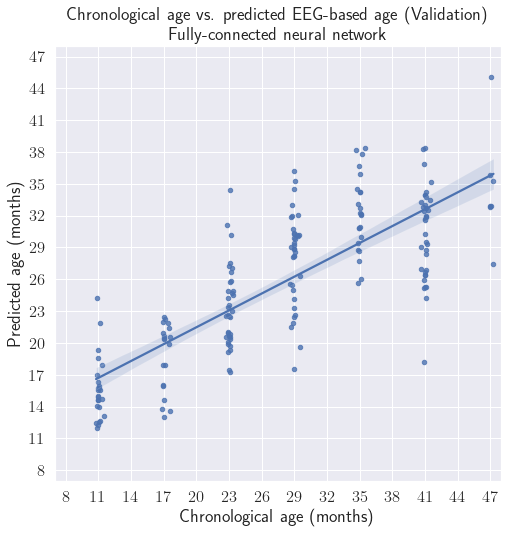

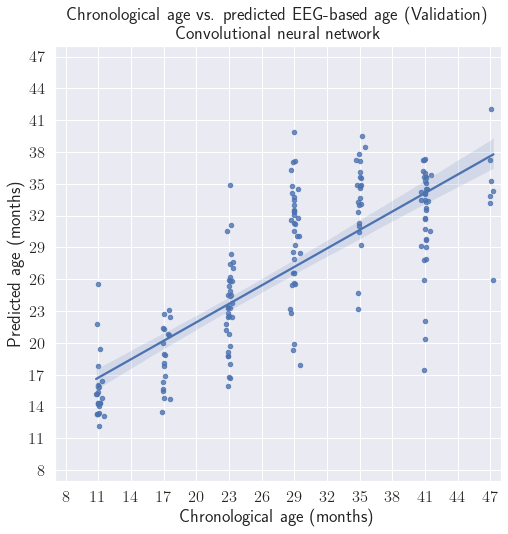

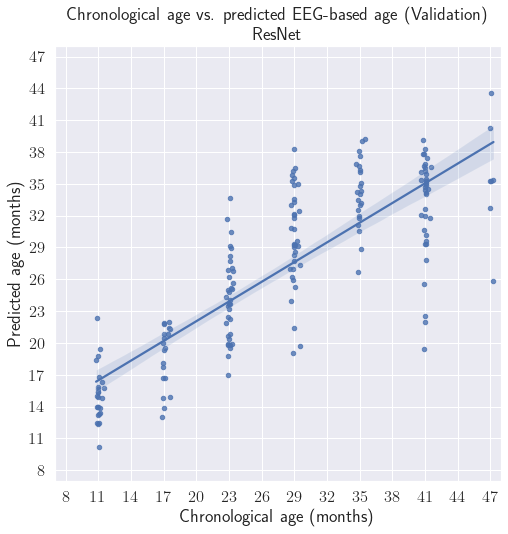

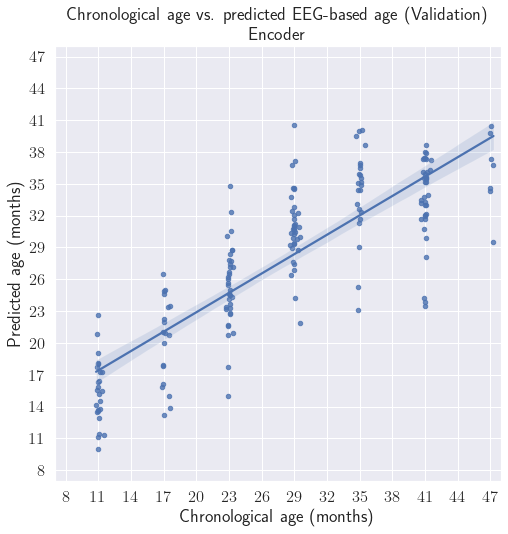

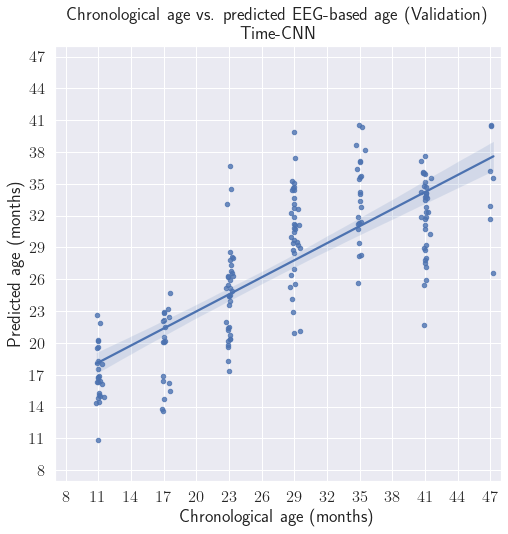

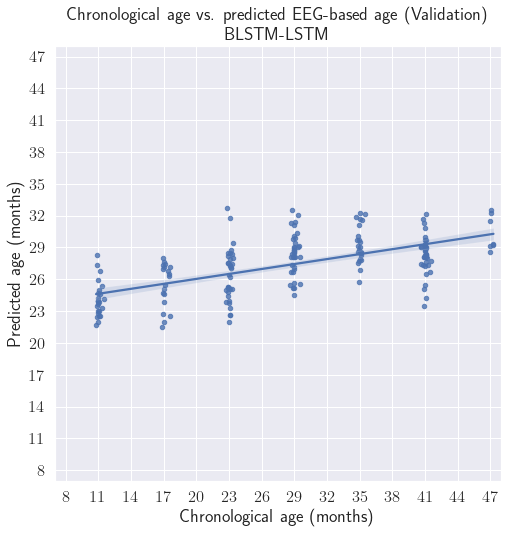

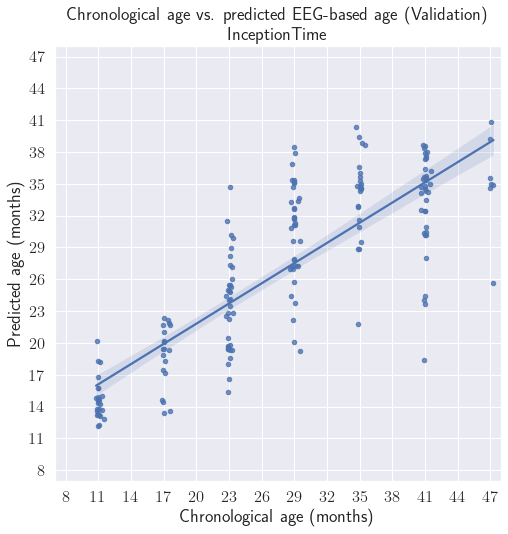

In [435]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(font_scale=1.5, rc={'text.usetex' : True})

save_path = "/Users/bbruns/Desktop/Visualisations/DeepLearning/True_Pred/"

for i, model in enumerate(models):
    fig, ax = plt.subplots(figsize=(8,8))
    
    x = model_performance_val[model]['y_true'] # Test/Train
    y = model_performance_val[model]['y_pred'] # Test/Train
  
    sns.regplot(x=x, y=y, scatter_kws={'s':20}) 

    ax.set_xlim(7, 48)
    ax.set_ylim(7, 48)

    ax.set_xticks(np.arange(8, 48, 3.0))
    ax.set_yticks(np.arange(8, 48, 3.0))

    ax.grid()
    ax.set_axisbelow(True)

    ax.set_xlabel('Chronological age (months)')
    ax.set_ylabel('Predicted age (months)')
    ax.set_title(f'Chronological age vs. predicted EEG-based age (Validation) \n {model_title[i]}') # Test/Train
    
    plt.grid()
    
    fig_name = f"VAL_{os.path.splitext(model)[0]}_true_pred.pdf" # Test/Train
    fig.savefig(os.path.join(save_path, fig_name), bbox_inches='tight')

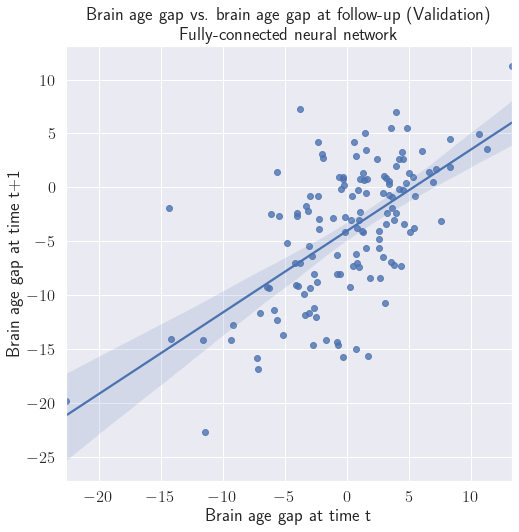

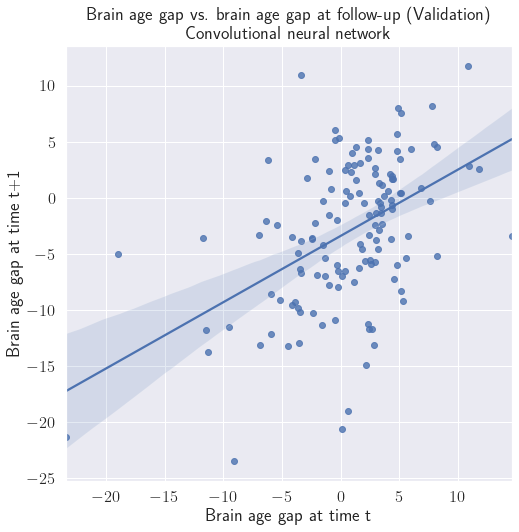

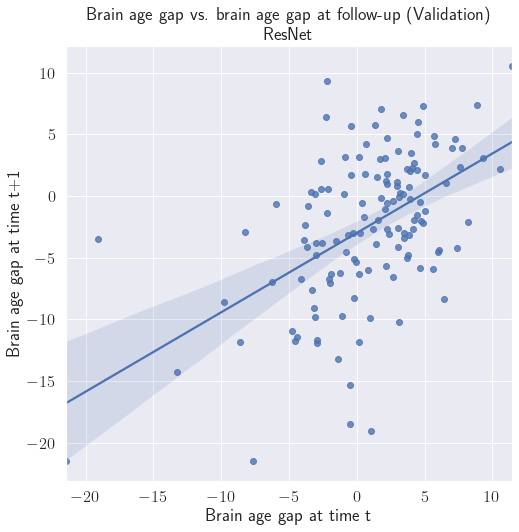

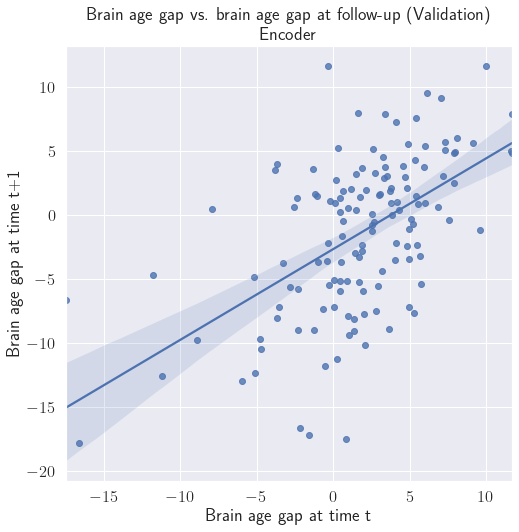

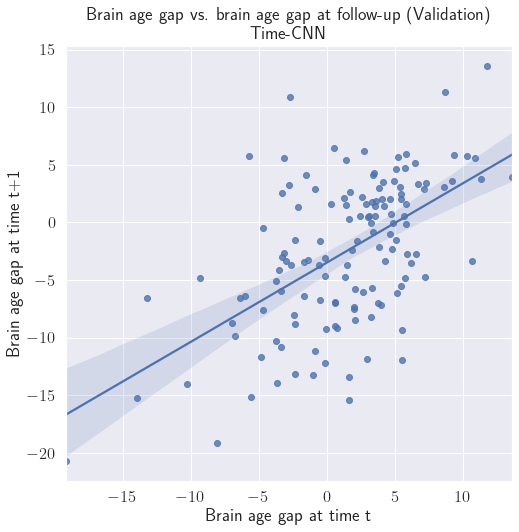

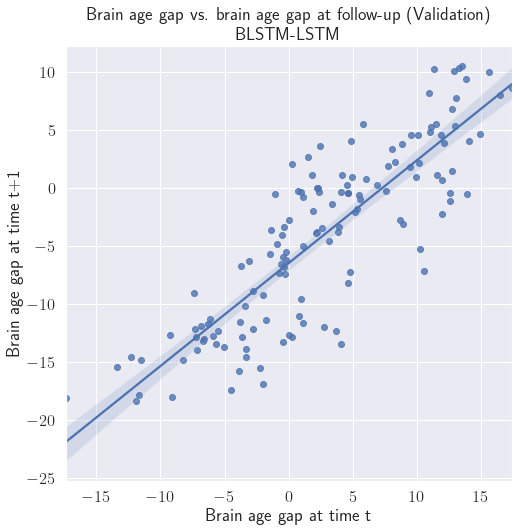

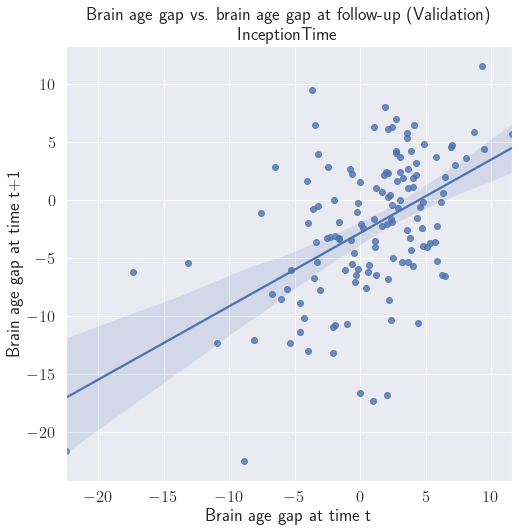

In [436]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(font_scale=1.5, rc={'text.usetex' : True})

save_path = "/Users/bbruns/Desktop/Visualisations/DeepLearning/ErrorN_ErrorN1/"

for i, model in enumerate(models):
    fig, ax = plt.subplots(figsize=(8,8))
    
    x = model_performance_val[model]['errors_time_N'] # Test/Train
    y = model_performance_val[model]['errors_time_N1'] # Test/Train

#     sns.regplot(x=x, y=y, scatter_kws={'s':20}) 
    sns.regplot(x=x, y=y) 

    ax.grid()
    ax.set_axisbelow(True)

    ax.set_xlabel('Brain age gap at time t')
    ax.set_ylabel('Brain age gap at time t+1')
    ax.set_title(f'Brain age gap vs. brain age gap at follow-up (Validation) \n {model_title[i]}') # Test/Train
    
    plt.grid()
    
    fig_name = f"VAL_{os.path.splitext(model)[0]}_error_stability.pdf" # Test/Train
    fig.savefig(os.path.join(save_path, fig_name), bbox_inches='tight')

<ipython-input-437-99b18d4e3730>:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8,8))


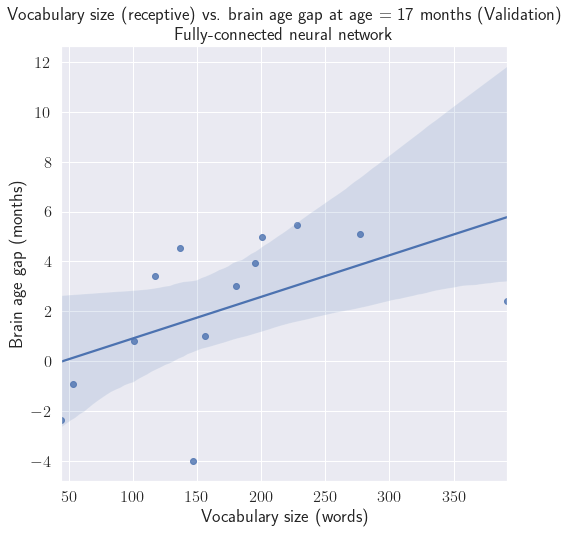

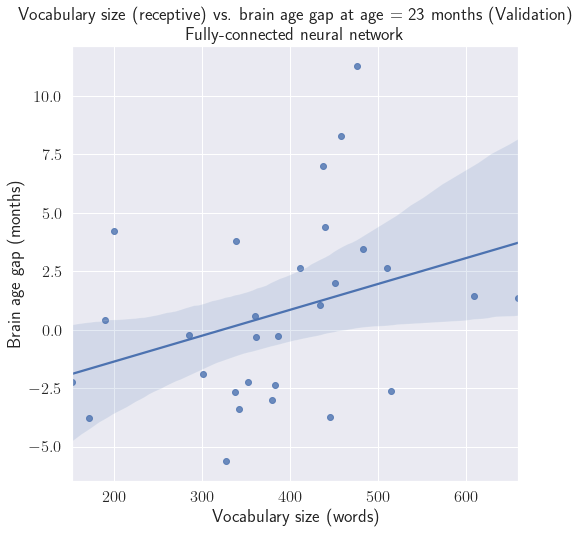

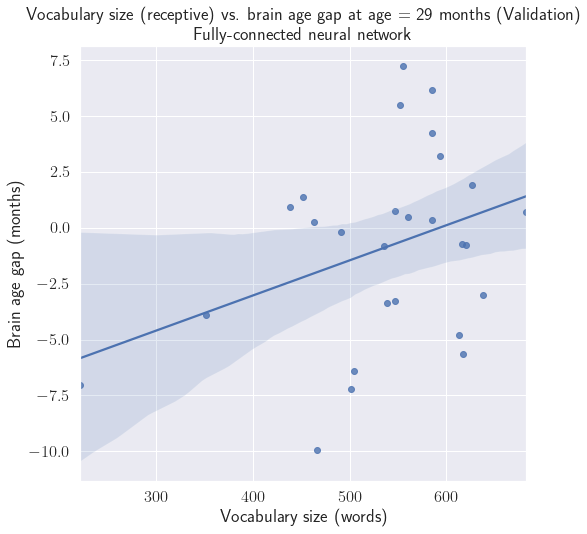

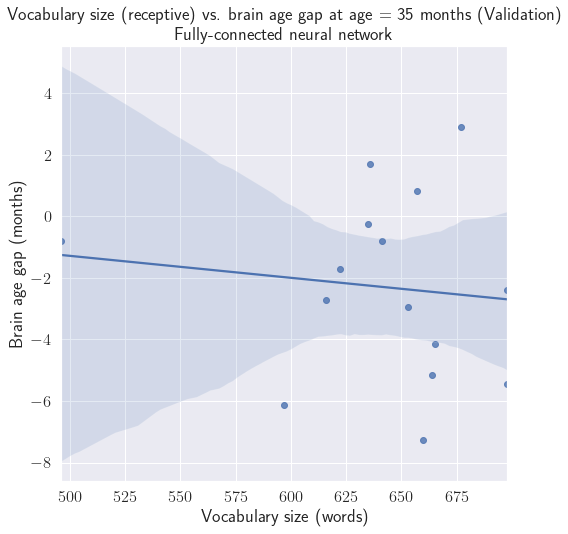

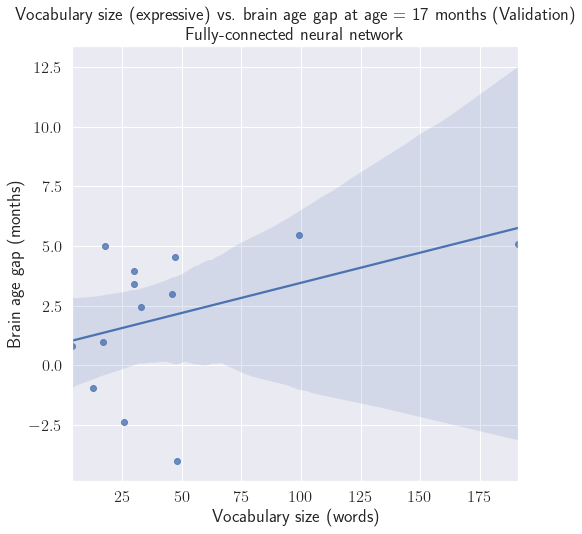

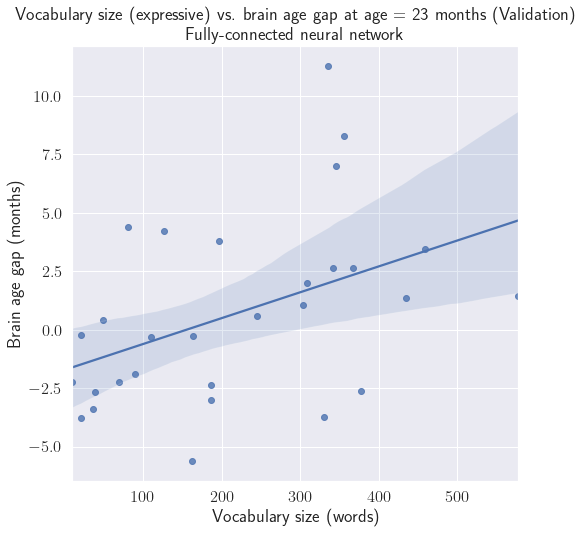

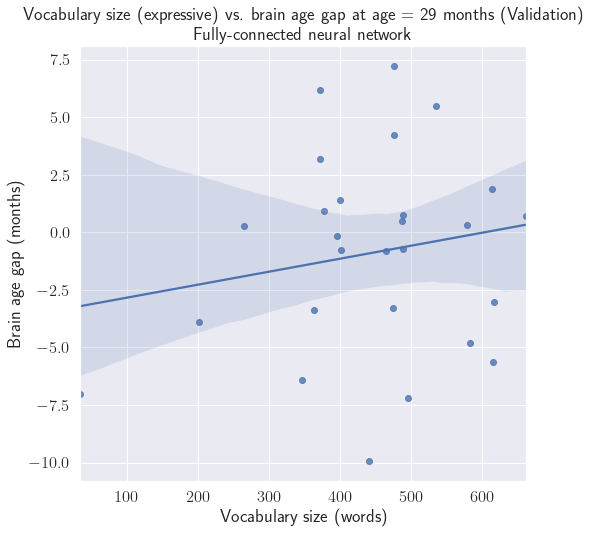

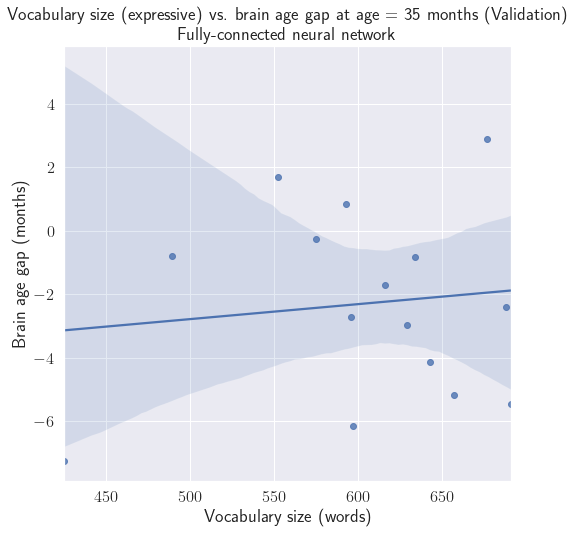

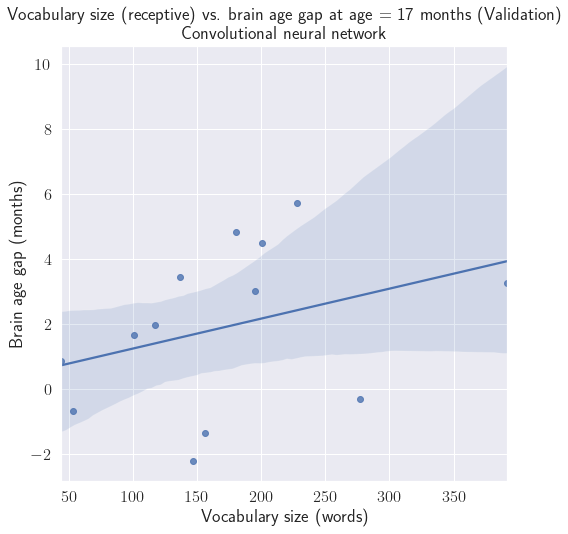

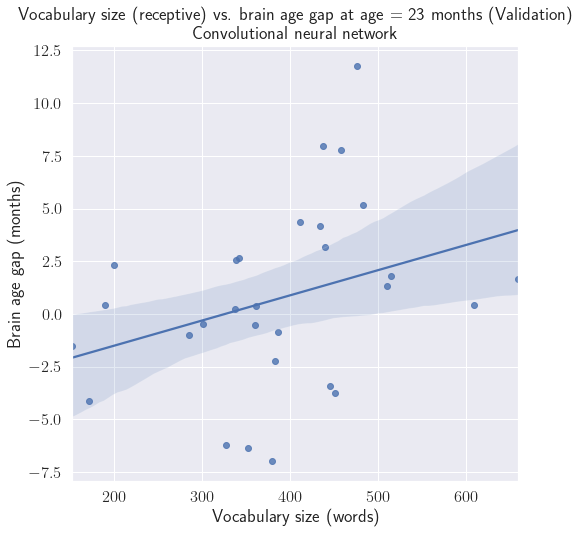

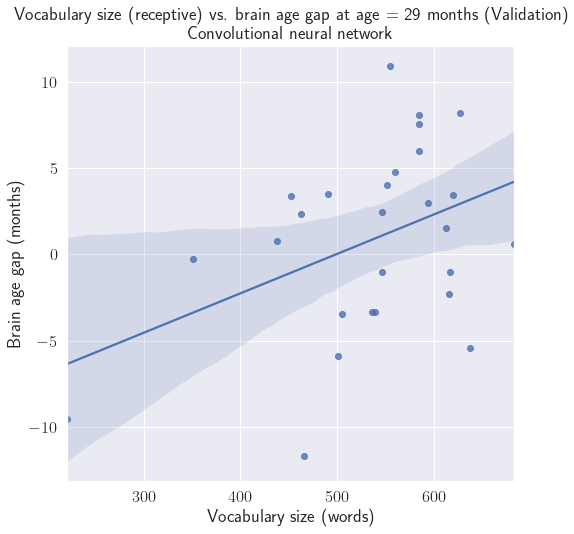

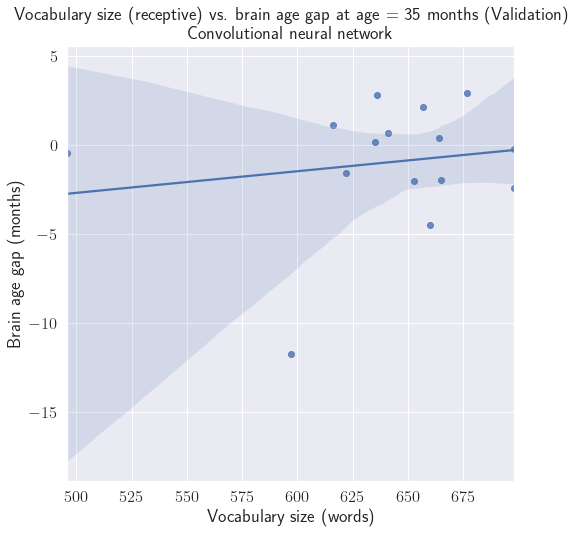

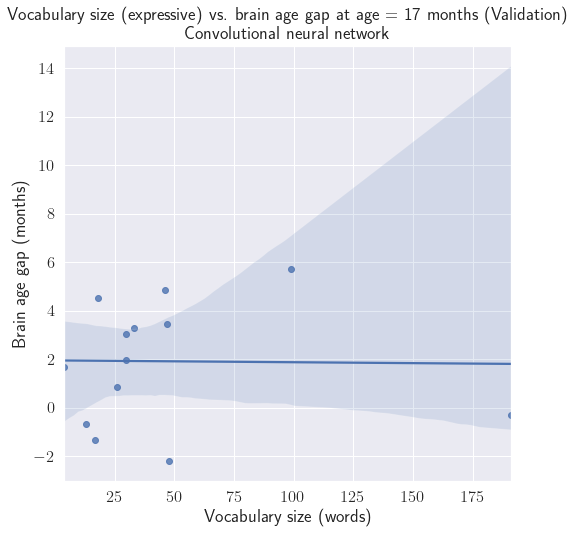

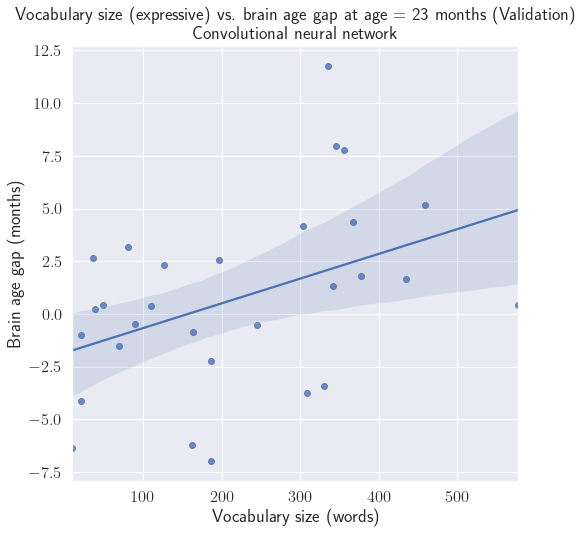

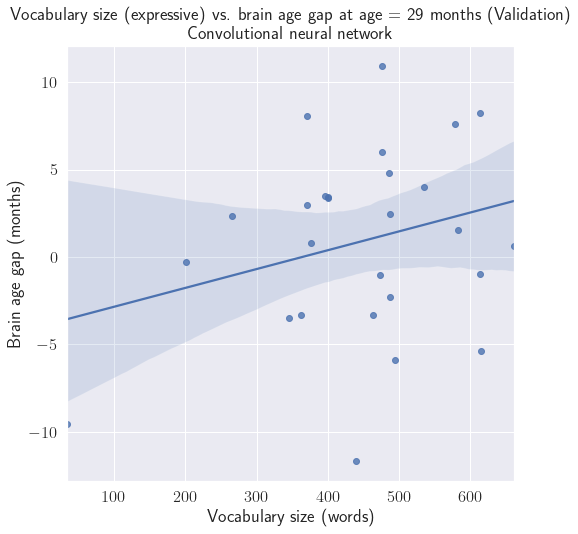

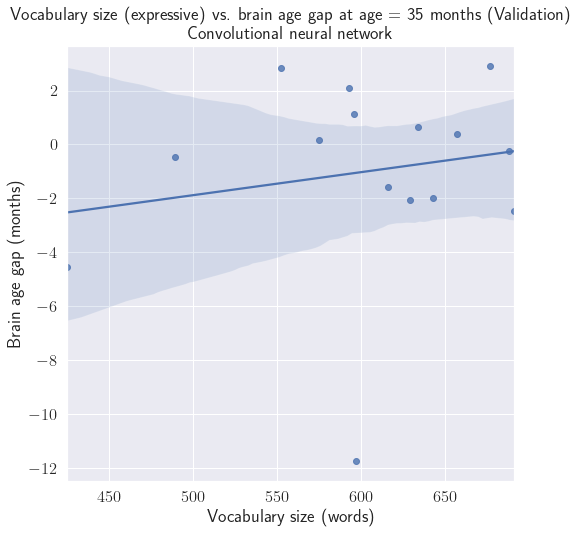

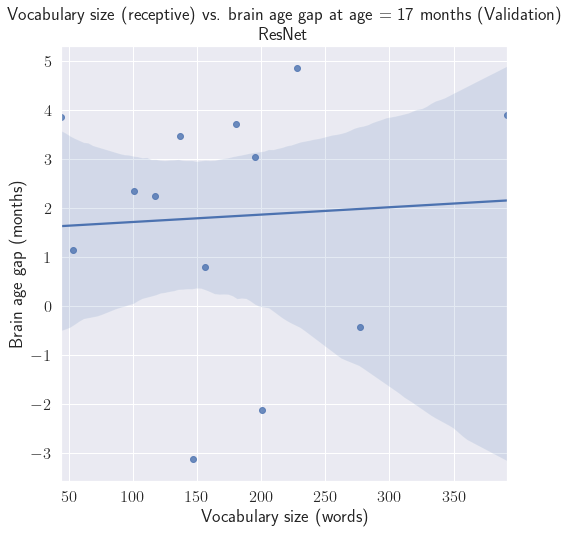

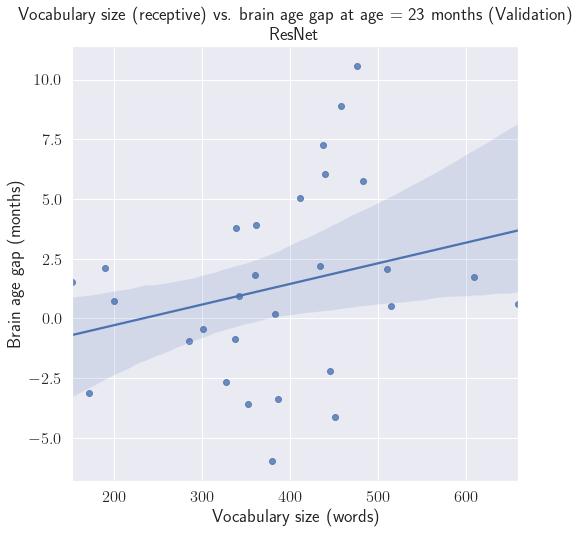

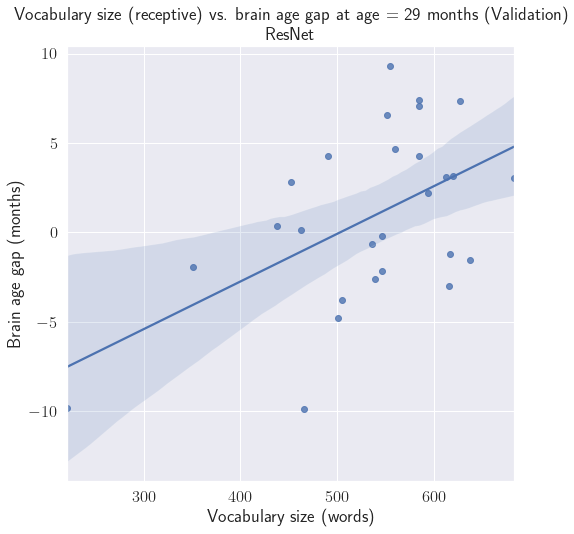

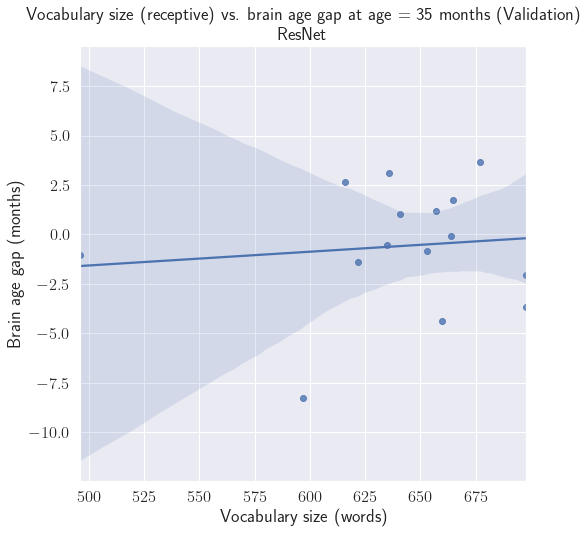

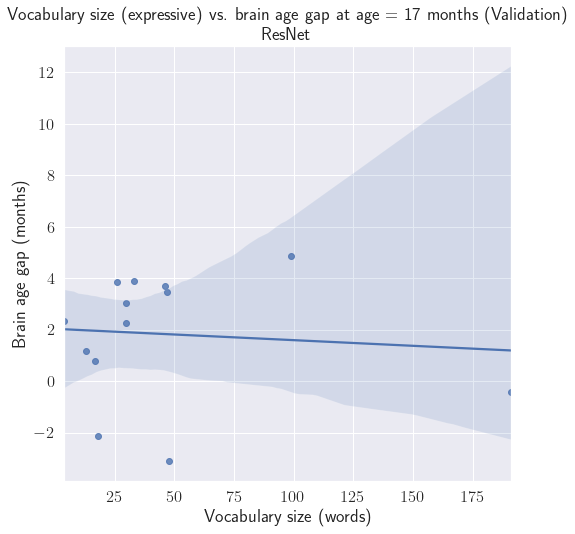

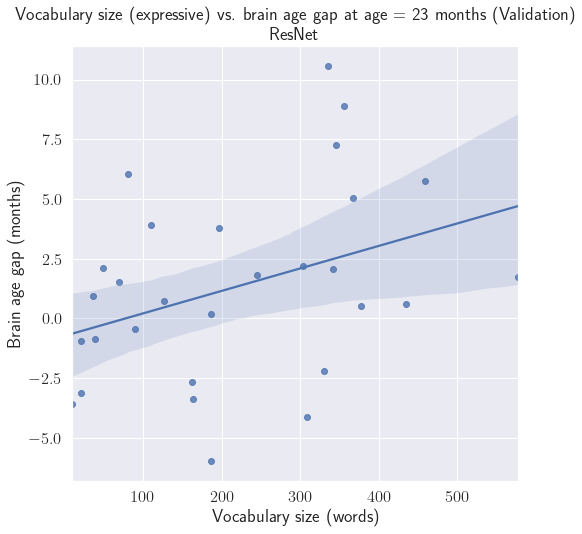

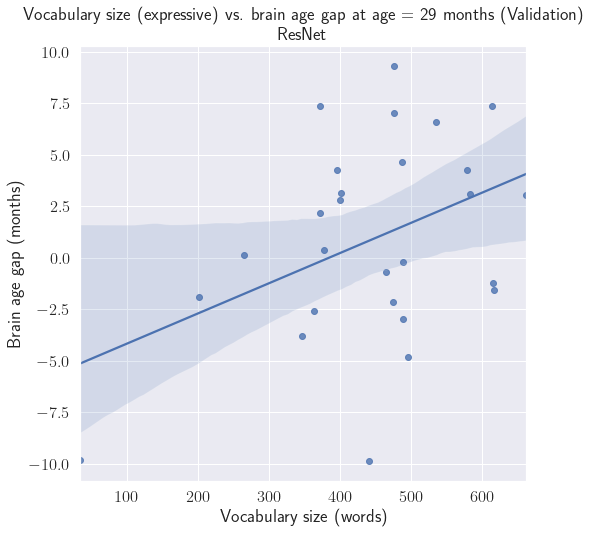

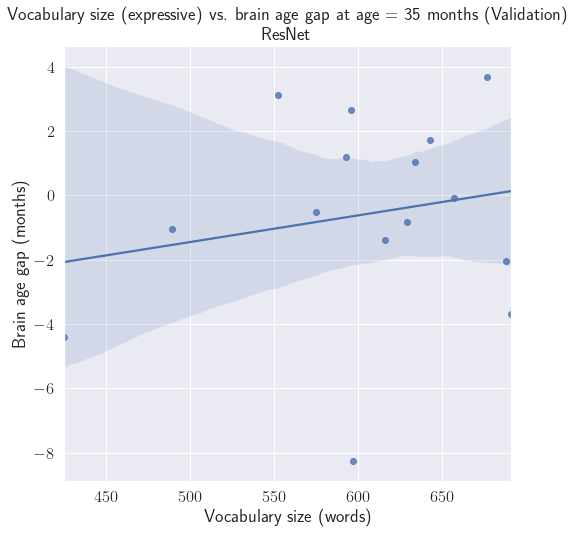

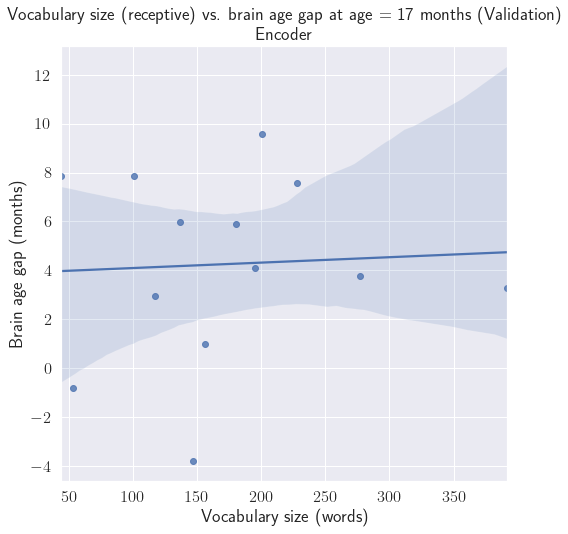

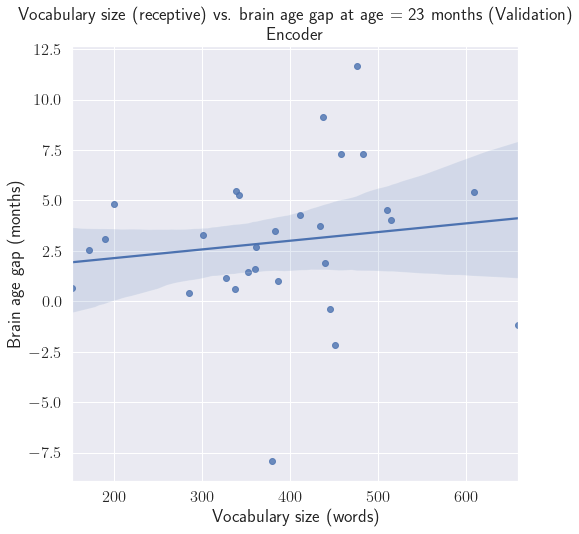

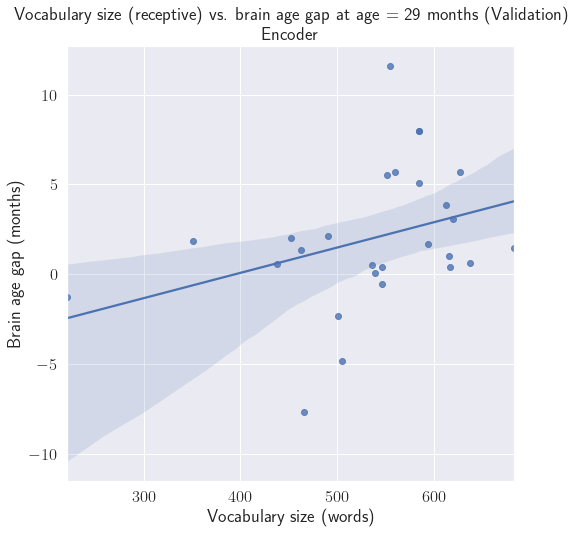

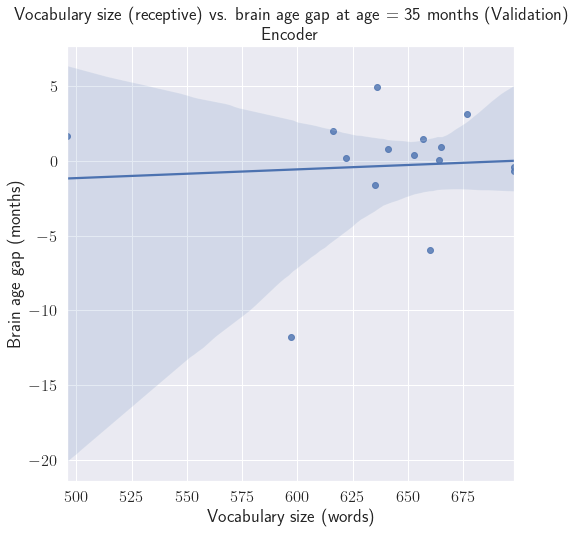

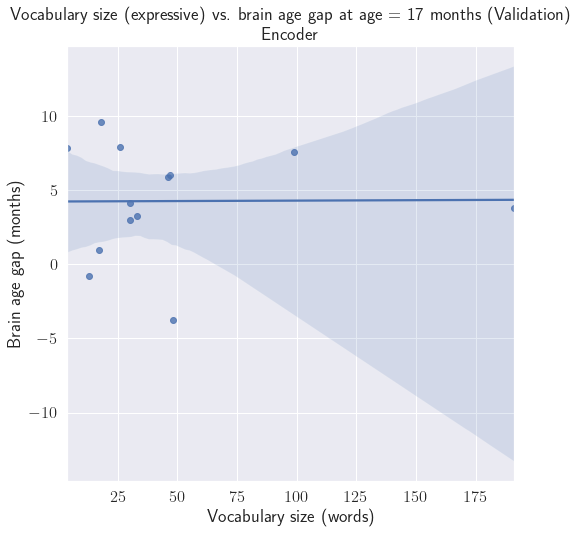

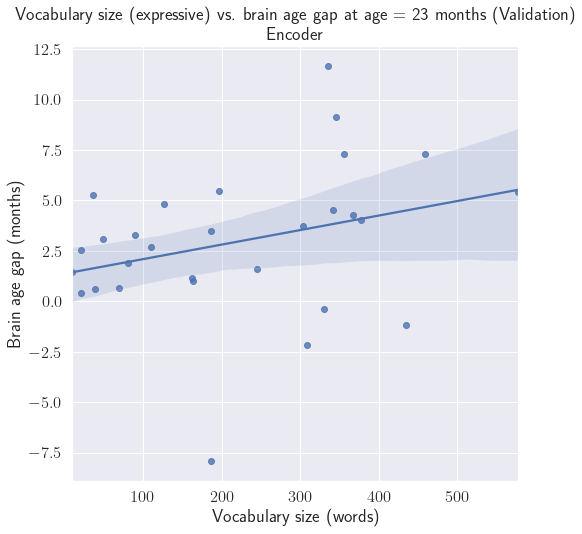

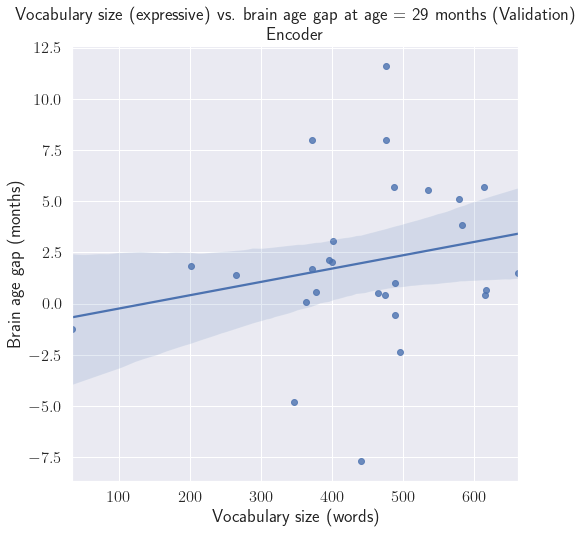

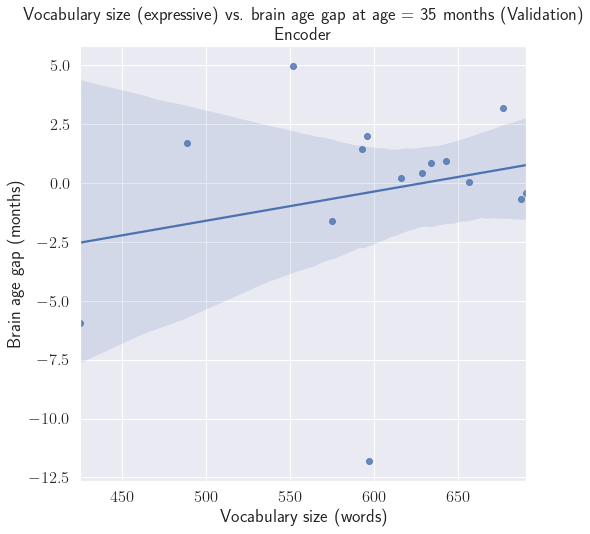

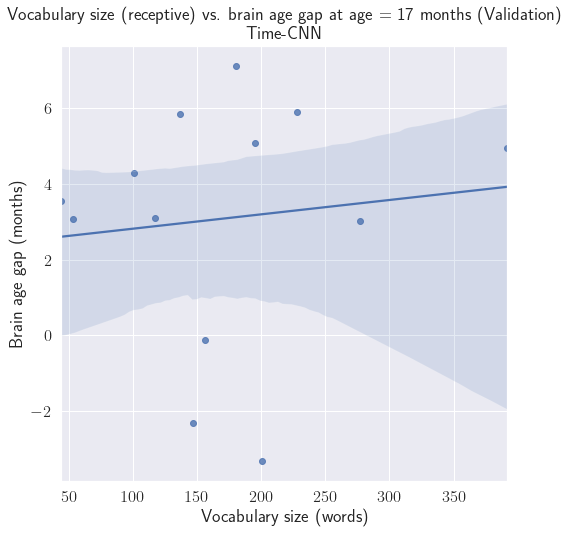

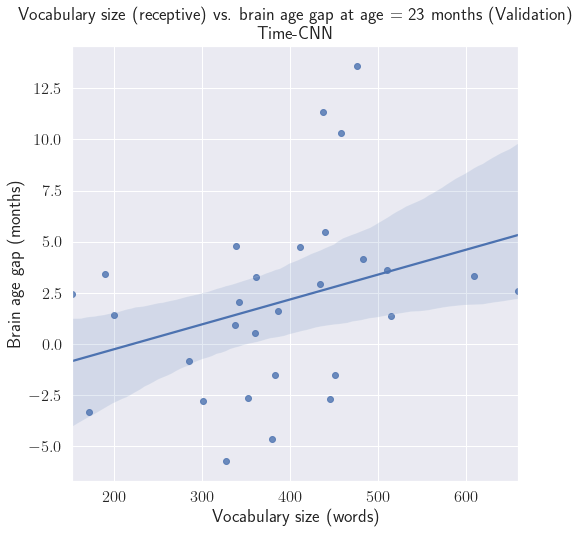

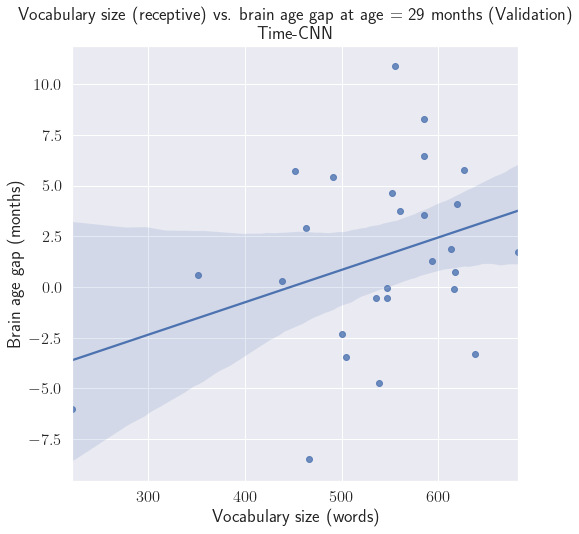

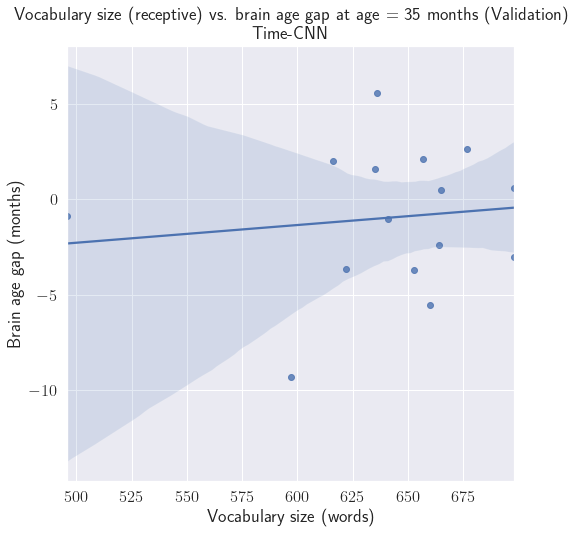

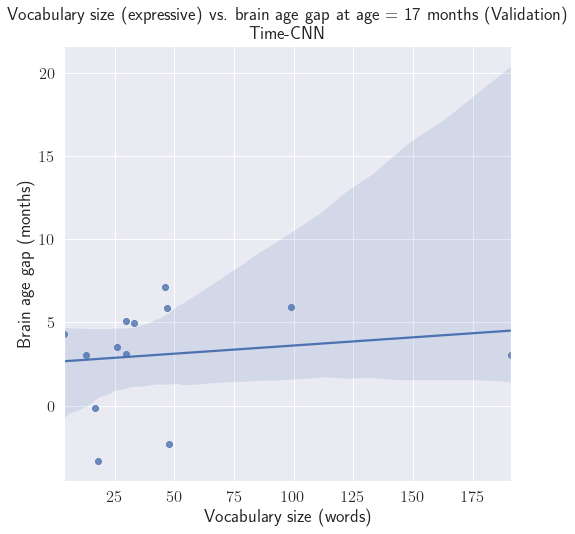

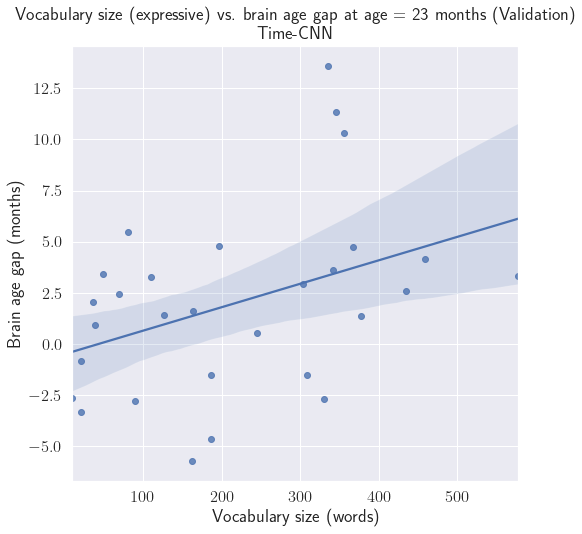

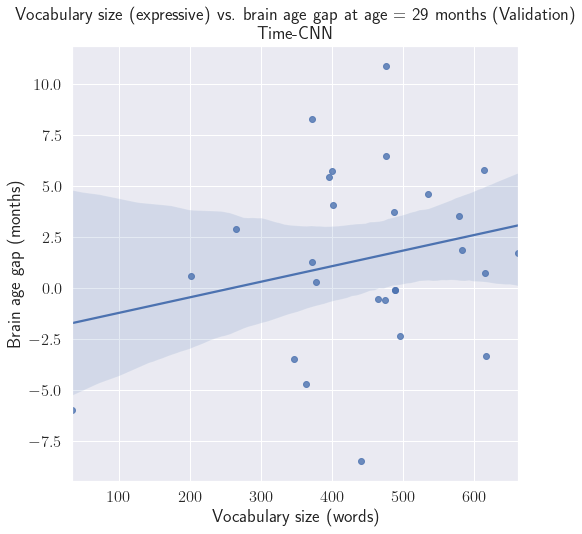

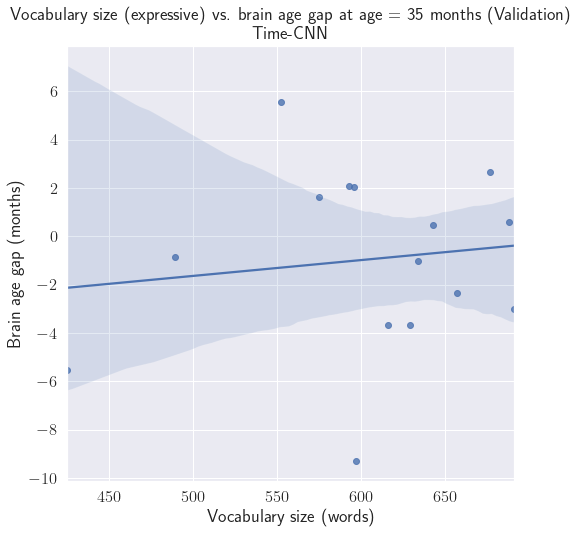

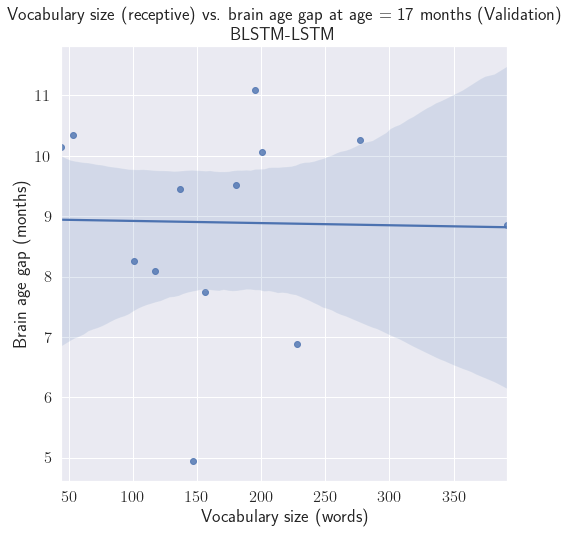

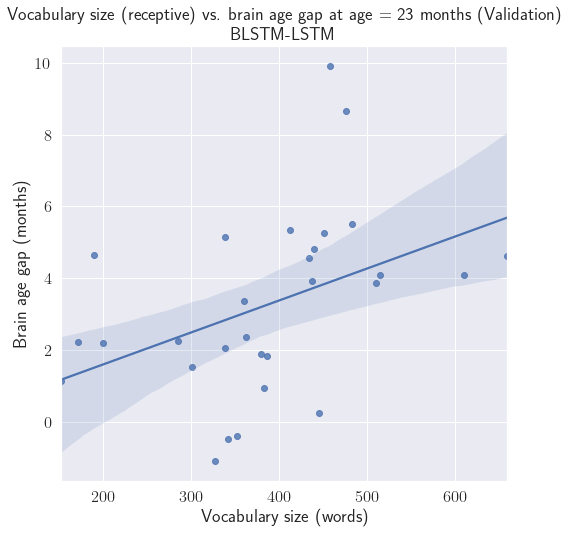

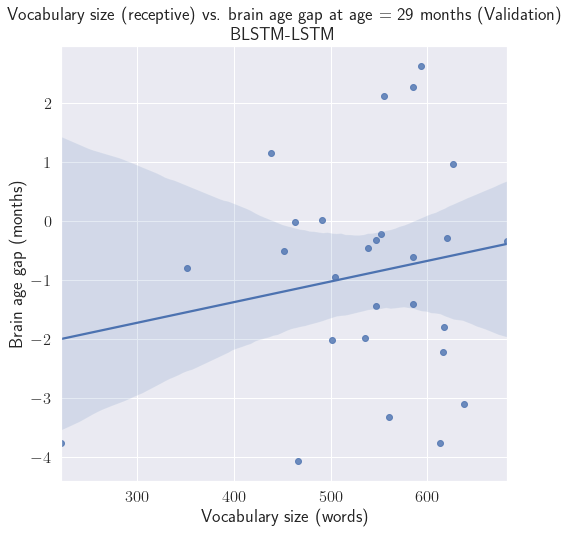

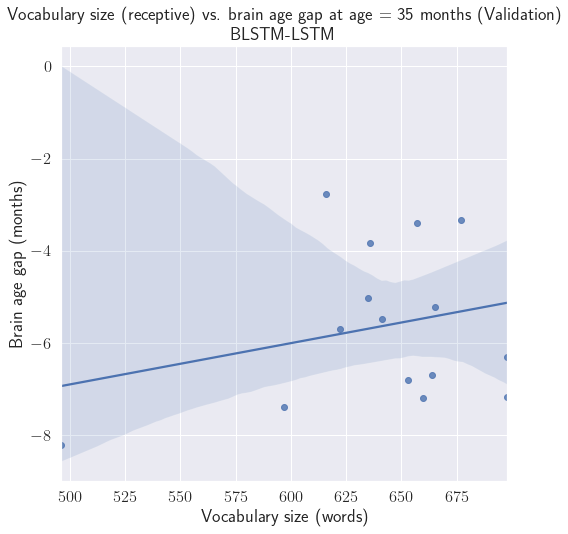

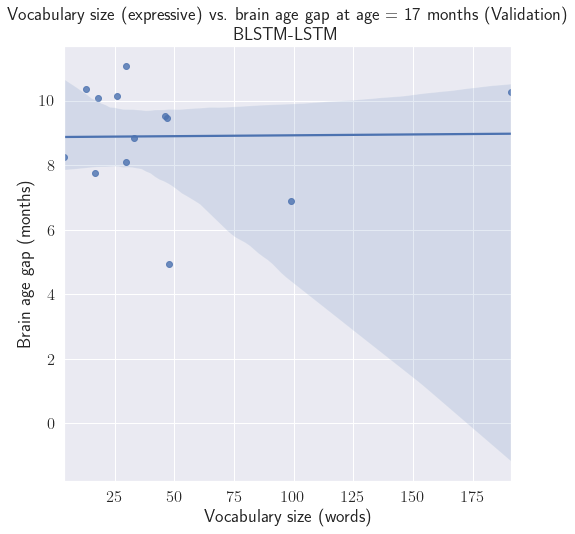

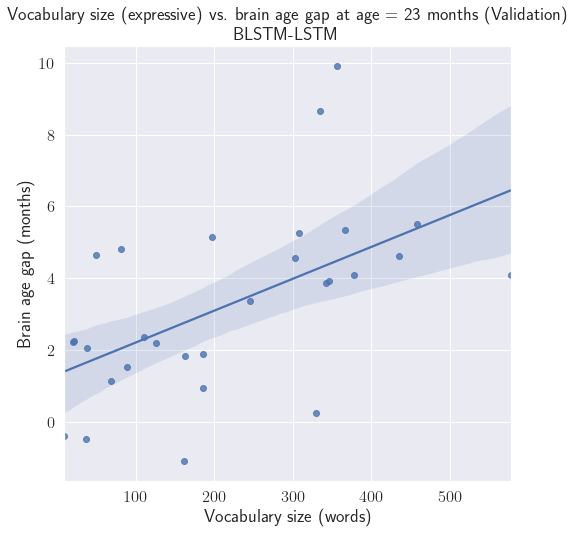

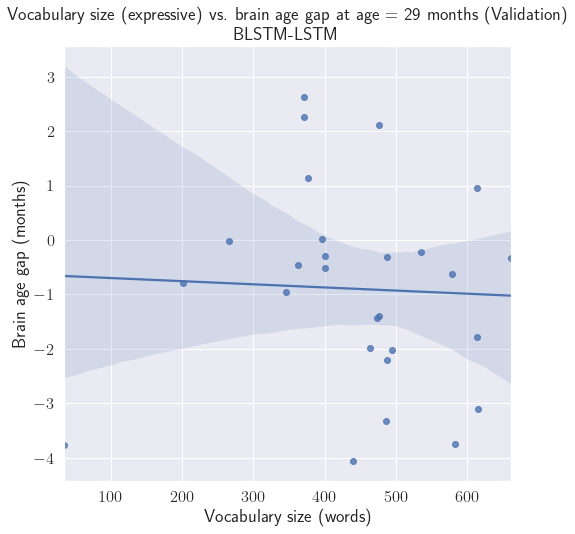

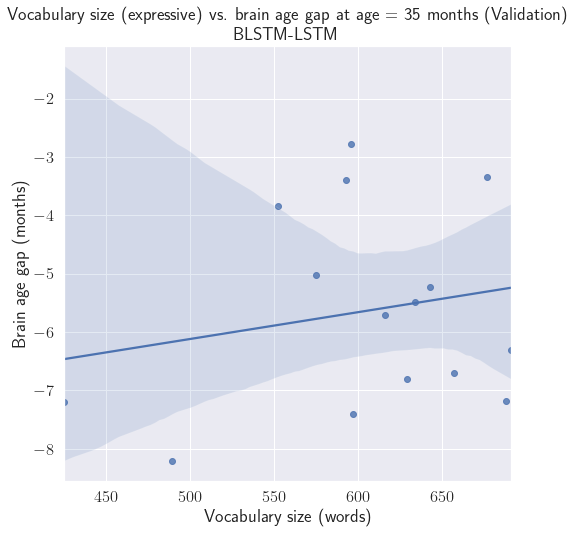

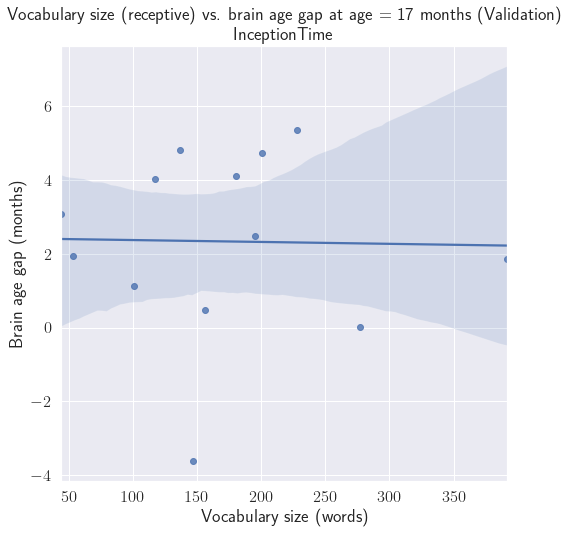

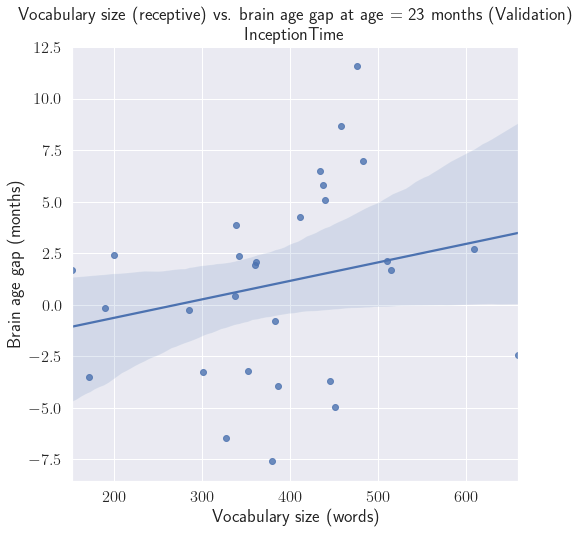

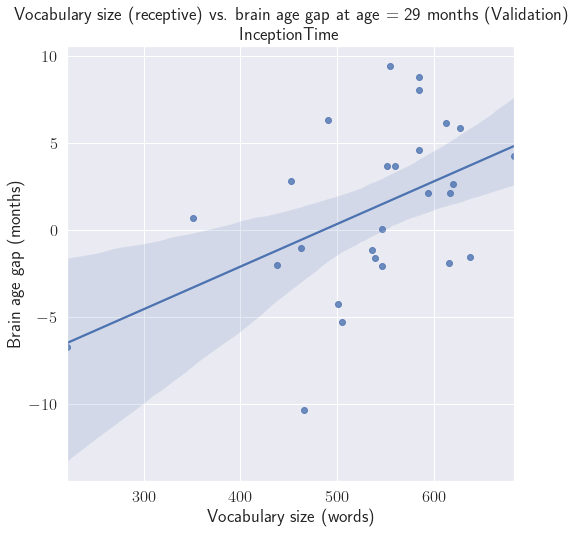

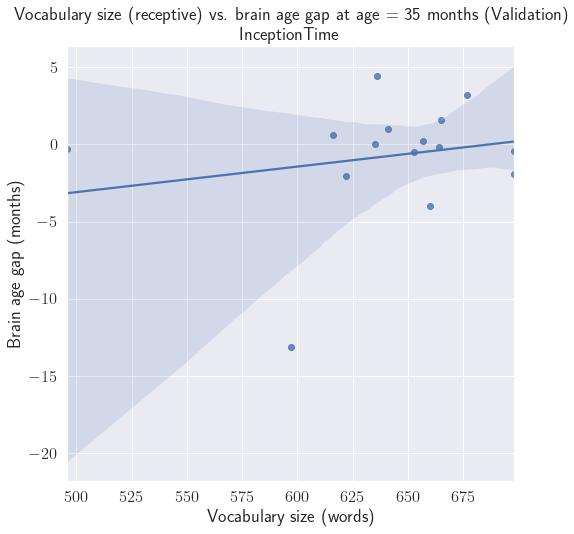

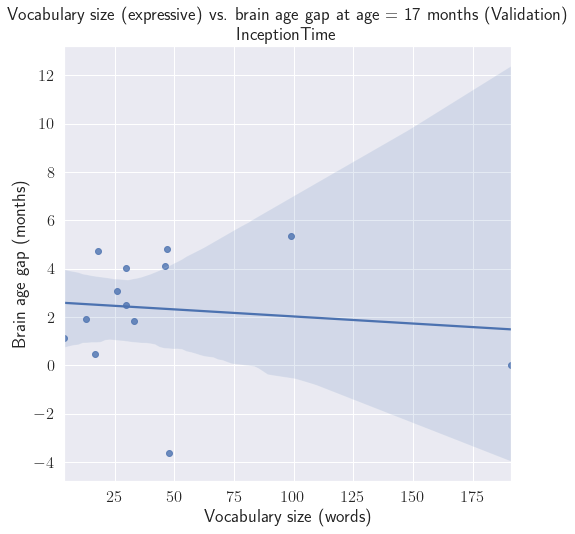

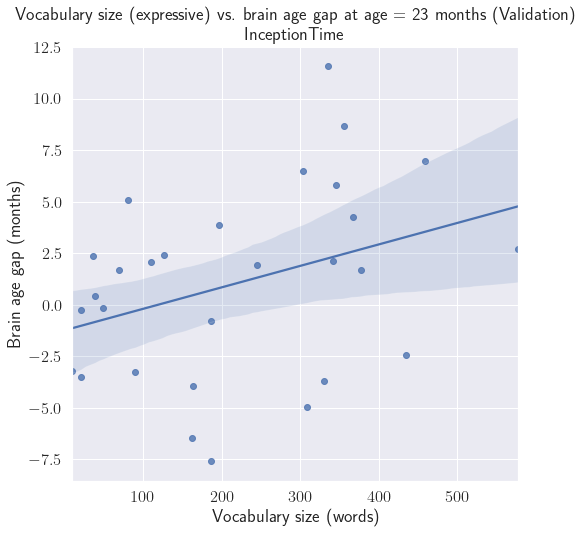

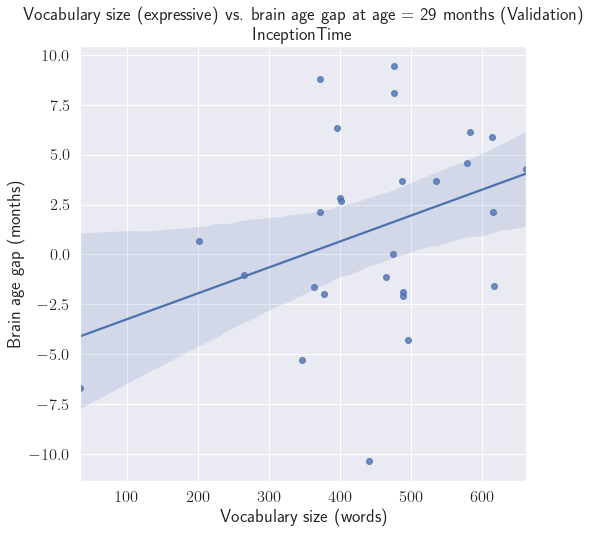

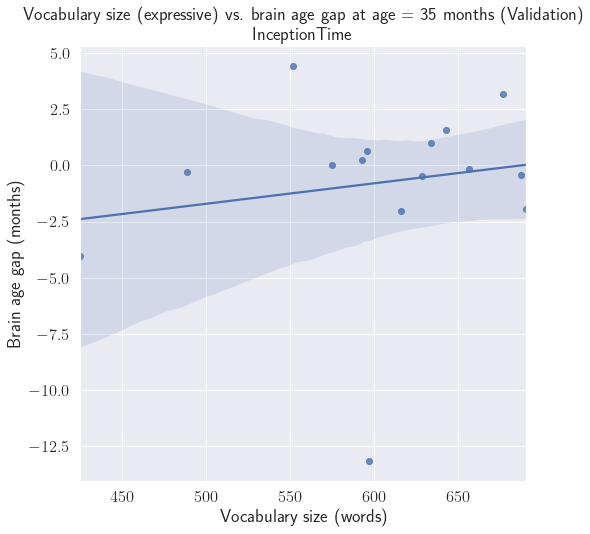

In [437]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(font_scale=1.5, rc={'text.usetex' : True})

save_path = "/Users/bbruns/Desktop/Visualisations/DeepLearning/"

categories = ["receptive", "productive"]
cat_names = ["receptive", "expressive"]

age_groups = [17, 23, 29, 35]
age_groups_path = ["Voc17/", "Voc23/", "Voc29/", "Voc35/"]

for i, model in enumerate(models):
    for j, category in enumerate(categories):
        for k, age_group in enumerate(age_groups):
            fig, ax = plt.subplots(figsize=(8,8))

            x = model_performance_val[model][f'vocabulary_sizes_{age_group}_{category}'] # Test/Train
            y = model_performance_val[model][f'brain_age_gaps_{age_group}_{category}'] # Test/Train

            sns.regplot(x=x, y=y) 

            ax.grid()
            ax.set_axisbelow(True)

            ax.set_xlabel('Vocabulary size (words)')
            ax.set_ylabel('Brain age gap (months)')
            ax.set_title(f'Vocabulary size ({cat_names[j]}) vs. brain age gap at age = {age_group} months (Validation) \n {model_title[i]}') # Test/Train

            plt.grid()

            fig_name = f"VAL_{os.path.splitext(model)[0]}_vocabulary_{cat_names[j]}_{age_group}.pdf" # Test/Train
            fig.savefig(os.path.join(save_path + age_groups_path[k], fig_name), bbox_inches='tight')

# 4. Model certainty / Monte Carlo Dropout

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, BatchNormalization, Dense, Conv1D, LeakyReLU, AveragePooling1D, Flatten, Reshape, MaxPooling1D
from tensorflow.keras.optimizers import Adam, Adadelta, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
import zarr

n_timesteps = 501
n_features = 30 
n_outputs = 1

input_shape = (n_timesteps, n_features)


import tensorflow_addons as tfa

def encoder_model():
    """ Returns the Encoder model from Ismail Fawaz et al. (2019). """
    input_layer = keras.layers.Input(input_shape)

    # conv block -1
    conv1 = keras.layers.Conv1D(filters=128,kernel_size=5,strides=1,padding='same')(input_layer)
    conv1 = tfa.layers.InstanceNormalization()(conv1)
    conv1 = keras.layers.PReLU(shared_axes=[1])(conv1)
    conv1 = keras.layers.Dropout(rate=0.2)(conv1, training=True)
    conv1 = keras.layers.MaxPooling1D(pool_size=2)(conv1)
    # conv block -2
    conv2 = keras.layers.Conv1D(filters=256,kernel_size=11,strides=1,padding='same')(conv1)
    conv2 = tfa.layers.InstanceNormalization()(conv2)
    conv2 = keras.layers.PReLU(shared_axes=[1])(conv2)
    conv2 = keras.layers.Dropout(rate=0.2)(conv2, training=True)
    conv2 = keras.layers.MaxPooling1D(pool_size=2)(conv2)
    # conv block -3
    conv3 = keras.layers.Conv1D(filters=512,kernel_size=21,strides=1,padding='same')(conv2)
    conv3 = tfa.layers.InstanceNormalization()(conv3)
    conv3 = keras.layers.PReLU(shared_axes=[1])(conv3)
    conv3 = keras.layers.Dropout(rate=0.2)(conv3, training=True)
    # split for attention
    attention_data = keras.layers.Lambda(lambda x: x[:,:,:256])(conv3)
    attention_softmax = keras.layers.Lambda(lambda x: x[:,:,256:])(conv3)
    # attention mechanism
    attention_softmax = keras.layers.Softmax()(attention_softmax)
    multiply_layer = keras.layers.Multiply()([attention_softmax,attention_data])
    # last layer
    dense_layer = keras.layers.Dense(units=256,activation='sigmoid')(multiply_layer)
    dense_layer = tfa.layers.InstanceNormalization()(dense_layer)
    # output layer
    flatten_layer = keras.layers.Flatten()(dense_layer)
    output_layer = keras.layers.Dense(1)(flatten_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model

In [23]:
from sklearn.utils import resample

def chunks(lst, n):
    """Yield successive n-sized chunks from list."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def make_predictions_MonteCarlo(model, IDs):
    """Takes in the IDs of the test subjects, divides all epochs in subsets of 30 and averages. 
        Final prediction for the subject is the median of all predictions on these subsets."""
    
    # Step 1: Make empty DataFrame to store the predictions in
    column_names = ["code", "age_group", "true_age", "predicted_age"]    
    df_pred = pd.DataFrame(columns = column_names)
        
    # Step 2: Iterate over subjects
    for ID in IDs:
        
        # Step 3: Find all files of a subject
        df_temp = df_metadata[df_metadata['code'] == ID]
    
        # Step 4: Find all the age groups the subject was found in
        ages_subject = sorted(list(set(df_temp['age_group'].tolist())))
        
        # Step 5: Loop over all the age groups the subject is in
        for age_group in ages_subject:            
            X_data = np.zeros((0, 30, 501))
            X_averaged_subsets = np.zeros((0, 30, 501))
            
            # Step 6: Concatenate data of files in the same age group
            for i, metadata_file in df_temp[df_temp['age_group'] == age_group].iterrows():
                filename = os.path.join(PATH_DATA_PROCESSED_DL, 'processed_raw_' + metadata_file['cnt_file'] + '.zarr')
                data_signal = zarr.open(os.path.join(filename), mode='r')
                                
                X_data = np.concatenate((X_data, data_signal), axis=0)
            
            np.random.shuffle(X_data) # Shuffle data for randomly picking epochs without replacement
            
            for subset in chunks(X_data, 30):
                X_data_mean = np.mean(subset[:,:,:], axis=0) # Average all epochs in subset
                X_data_mean = np.expand_dims(X_data_mean, axis=0)
                X_averaged_subsets = np.concatenate((X_averaged_subsets, X_data_mean), axis=0)
            
            X = np.swapaxes(X_averaged_subsets, 1, 2)
                                            
            # Step 7: Predict age of the averaged epochs
            predicted_ages = model.predict(X).flatten()
            predicted_age = np.median(predicted_ages)
            
            true_age = df_temp[df_temp['age_group'] == age_group]['age_months'].values[0]
            
            # Step 8: Create a row for the predictions DataFrame

            
            # Step 9: Monte Carlo Dropout, predict 50 ages
            predicted_ages_MC = []
            
            for i in range(50):
                predicted_ages = model.predict(X).flatten()
                predicted_age = np.median(predicted_ages)
                
                predicted_ages_MC.append(predicted_age)
                
            df_row = {"code": ID, 
                      "age_group": age_group, 
                      "true_age": true_age, 
                      "predicted_age": predicted_age, 
                      "predicted_ages_MC": predicted_ages_MC
                     }
    
            
            # Step 10: Add the row to the DataFrame
            df_pred = df_pred.append(df_row, ignore_index=True)
            
    return df_pred

In [24]:
%%time

from statistics import stdev, mean

model_name = 'Encoder_regressor_FINAL_LOCAL.hdf5'

model = encoder_model()
model.load_weights(os.path.join(PATH_MODELS, model_name))

df_pred_MC = make_predictions_MonteCarlo(model, IDs_test)

sd_list = []
for index, row in df_pred_MC.iterrows():
    sd_list.append(np.std(row['predicted_ages_MC']))
    
print(f"Mean standard deviation for model {model_name} (SD Monte Carlo): {mean(sd_list)}")


Mean standard deviation for model Encoder_regressor_FINAL_LOCAL.hdf5 (SD Monte Carlo): 0.37979787588119507
CPU times: user 4h 18min 28s, sys: 16min 59s, total: 4h 35min 28s
Wall time: 1h 9min 6s


In [25]:
%%time

from statistics import stdev, mean

model_name = 'Encoder_regressor_FINAL_LOCAL.hdf5'

model = encoder_model()
model.load_weights(os.path.join(PATH_MODELS, model_name))

df_pred_MC_val = make_predictions_MonteCarlo(model, IDs_val)

sd_list_val = []
for index, row in df_pred_MC_val.iterrows():
    sd_list_val.append(np.std(row['predicted_ages_MC']))
    
print(f"Mean standard deviation for model {model_name} (SD Monte Carlo): {mean(sd_list_val)}")

Mean standard deviation for model Encoder_regressor_FINAL_LOCAL.hdf5 (SD Monte Carlo): 0.37979966402053833
CPU times: user 4h 37s, sys: 15min 20s, total: 4h 15min 58s
Wall time: 1h 1min 50s


In [26]:
%%time

from statistics import stdev, mean

model_name = 'Encoder_regressor_FINAL_LOCAL.hdf5'

model = encoder_model()
model.load_weights(os.path.join(PATH_MODELS, model_name))

df_pred_MC_train = make_predictions_MonteCarlo(model, IDs_train)

sd_list_train = []
for index, row in df_pred_MC_train.iterrows():
    sd_list_train.append(np.std(row['predicted_ages_MC']))
    
print(f"Mean standard deviation for model {model_name} (SD Monte Carlo): {mean(sd_list_train)}")

Mean standard deviation for model Encoder_regressor_FINAL_LOCAL.hdf5 (SD Monte Carlo): 0.3921809494495392
CPU times: user 18h 8min 58s, sys: 1h 10min 14s, total: 19h 19min 13s
Wall time: 4h 29min 59s


In [47]:
age_groups = [11, 17, 23, 29, 35, 41, 47]

for age_group in age_groups:
    df_MC_temp = df_pred_MC.loc[df_pred_MC['age_group'] == age_group] # Train/val/test
#     print(len(df_MC_temp))
    SD_list = [np.std(value) for value in df_MC_temp['predicted_ages_MC'].values]
    mean_SD = mean(SD_list)
    mean_SD = float(mean_SD)
    
#     print(f"{mean_SD} & ", end="")
    print(f"{round(mean_SD, 3)} & ", end="")

0.412 & 0.398 & 0.383 & 0.387 & 0.352 & 0.357 & 0.425 & 

In [42]:
df_pred_MC_val

,code,age_group,true_age,predicted_age,predicted_ages_MC
0,174,11,11.000000,19.628862,"[20.83427, 20.247383, 21.01009, 20.246946, 19...."
1,174,17,17.000000,21.568748,"[21.521915, 20.707378, 20.92734, 21.956352, 22..."
2,174,23,23.000000,26.788845,"[26.628893, 26.347979, 26.54557, 26.337818, 26..."
3,174,29,29.000000,29.988735,"[30.01419, 30.041164, 28.860882, 30.248909, 28..."
4,174,35,35.000000,34.187363,"[33.295876, 33.958336, 33.243217, 33.953156, 3..."
...,...,...,...,...,...
176,164,35,34.966667,36.230240,"[36.918236, 36.836304, 37.478615, 37.233795, 3..."
177,164,41,40.900000,31.694832,"[31.537064, 30.927582, 30.854279, 30.801151, 3..."
178,452,11,11.100000,10.378257,"[10.087508, 10.114459, 10.320694, 10.124725, 1..."
179,452,23,23.133333,25.593418,"[25.80515, 25.280655, 24.979328, 25.252167, 24..."


In [48]:
from joblib import dump, load

# output_file_test = os.path.join(PATH_MODELS, 'MC_test.joblib')
# output_file_train = os.path.join(PATH_MODELS, 'MC_train.joblib')
# output_file_val = os.path.join(PATH_MODELS, 'MC_val.joblib')


# dump(df_pred_MC, output_file_test)
# dump(df_pred_MC_train, output_file_train)
# dump(df_pred_MC_val, output_file_val)

['/Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/MC_val.joblib']